In [30]:
import os
import numpy as np
import mido
import glob
from matplotlib import pyplot as plt

In [31]:
PROJECT_PATH = '/raid/shumnov/music-style-performer/'
FILES_PATH = PROJECT_PATH + 'data/maestro-voices/'#'data/GiantMIDI-voices/'

In [32]:
mid = mido.MidiFile(FILES_PATH + 'Agnew, Roy, 2 Piano Solos, FxJoaQcBkvw.mid')

FileNotFoundError: [Errno 2] No such file or directory: '/raid/shumnov/music-style-performer/data/maestro-voices/Agnew, Roy, 2 Piano Solos, FxJoaQcBkvw.mid'

In [33]:
mid

MidiFile(type=1, ticks_per_beat=384, tracks=[
  MidiTrack([
    MetaMessage('key_signature', key='C', time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('set_tempo', tempo=500000, time=0),
    Message('note_on', channel=0, note=41, velocity=48, time=20671),
    Message('note_on', channel=0, note=43, velocity=49, time=446),
    Message('note_off', channel=0, note=41, velocity=0, time=45),
    Message('note_off', channel=0, note=43, velocity=0, time=661),
    Message('note_on', channel=0, note=39, velocity=41, time=649),
    Message('note_off', channel=0, note=39, velocity=0, time=2441),
    Message('note_on', channel=0, note=36, velocity=52, time=1325),
    Message('note_off', channel=0, note=36, velocity=0, time=1096),
    Message('note_on', channel=0, note=41, velocity=57, time=277),
    Message('note_off', channel=0, note=41, velocity=0, time=920),
    Message('note_on', channel=0, note=4

In [34]:
def Note(tone, time, duration, velocity, dt):
    return [tone, time, duration, velocity, dt]

In [35]:
LINE_MIN_LENGTH = 20
FIXED_LINE_LENGTH = 20

In [36]:
def track2line(track, ticks_per_beat):
    line = []

    time = 0
    for m in track:
        time += m.time / ticks_per_beat / 2

        if m.type == 'note_on' and m.velocity > 0:
            if len(line) > 0:
                line[-1][4] = time - line[-1][1]
            line.append(Note(m.note, time, -1, m.velocity, -1))
            
        elif m.type == 'note_off' or (m.type == 'note_on' and m.velocity == 0):
            i = 1
            while line[-i][0] != m.note:
                i += 1
            
            line[-i][2] = time - line[-i][1]
    
    if len(line) > 0:
        line[-1][4] = line[-1][2]
            
    return line

            
def split_line(line):
    lines = []
    prev = 0
    
    for i in range(1, len(line)):
        pause = line[i - 1][4] - line[i - 1][2]
        
        if pause > 5: # diff > 10 or (line[i - 1][2] > 100 and line[i - 1][2] * 5 < diff):
            if i - prev > LINE_MIN_LENGTH:
                lines.append(line[prev:i])
                lines[-1][-1][4] = lines[-1][-1][2]
            prev = i
            
    if len(line) - prev > LINE_MIN_LENGTH:
        lines.append(line[prev:])
        
    return lines


def mid2lines(mid):
    lines = []
    
    for t in mid.tracks:
        line = track2line(t, mid.ticks_per_beat)
        splitted = split_line(line)
        
        lines.extend(splitted)
        
    return lines


In [37]:
def show(l):
    x = []
    for i in l:
        x.extend([i[1], i[1] + i[4]])
        
    y = []
    for i in l:
        y.extend([i[0], i[0]])
    
    plt.plot(x, y, '.-')

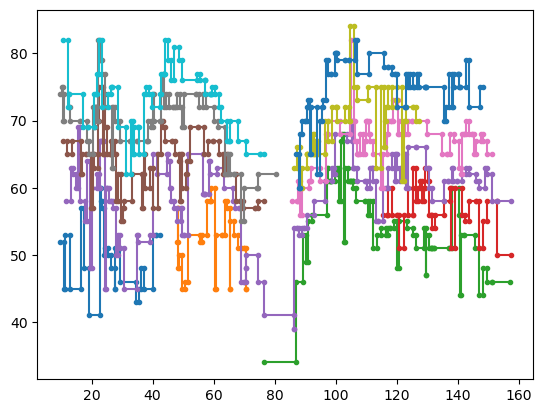

11


In [38]:
lines = mid2lines(mid)

for l in lines:
    show(l)

plt.show()

print(len(lines))

In [39]:
from numpy.lib.stride_tricks import sliding_window_view

def stride_line(line):
    line = np.array(line, dtype=np.float32)

    # prev = line[0][0]
    # line[0][0] = 0
    # for i in range(1, len(line)):
    #     line[i][0] = line[i][0] - prev
    #     prev += line[i][0]

    # line[..., 1] -= line[0][1]

    return np.squeeze(sliding_window_view(line, (FIXED_LINE_LENGTH, 5)))
    
def stride(lines):
    res = stride_line(lines[0])
    
    for l in lines[1:]:
        line_strided = stride_line(l)
        res = np.append(res, line_strided, axis=0)
    
    return res


In [40]:
np.set_printoptions(suppress=True)

strided = stride(lines)
strided = np.delete(strided, (1), axis=2)
print(strided.shape)
print(strided)

(340, 20, 4)
[[[52.          0.04947917 25.          1.4231771 ]
  [45.          0.01432292 44.          0.2721354 ]
  [53.          1.4466146  59.          1.4479166 ]
  ...
  [43.          1.1536459  51.          1.1497396 ]
  [45.          0.01432292 46.          0.6171875 ]
  [48.          0.94921875 59.          0.9322917 ]]

 [[45.          0.01432292 44.          0.2721354 ]
  [53.          1.4466146  59.          1.4479166 ]
  [45.          0.01432292 40.          3.8098958 ]
  ...
  [45.          0.01432292 46.          0.6171875 ]
  [48.          0.94921875 59.          0.9322917 ]
  [45.          0.09505209 37.          3.0989583 ]]

 [[53.          1.4466146  59.          1.4479166 ]
  [45.          0.01432292 40.          3.8098958 ]
  [57.          0.41927084 64.          0.7890625 ]
  ...
  [48.          0.94921875 59.          0.9322917 ]
  [45.          0.09505209 37.          3.0989583 ]
  [53.          0.34765625 40.          0.87109375]]

 ...

 [[72.          0.471

In [41]:
def process_file(fname):
    mid = mido.MidiFile(FILES_PATH + fname)
    
    lines = mid2lines(mid)
    if len(lines) > 0:
        strided = stride(lines)
        return strided


def process_files(filenames):
    res = process_file(filenames[0])
    n = len(filenames)
    
    for i, fname in enumerate(filenames[1:]):
        processed = process_file(fname)
        if processed is not None:
            res = np.append(res, processed, axis=0)
           
        if (i + 1) % 500 == 0:
            print(f'files: {i + 1}/{n}; dset len: {len(res)}')
            
        if len(res) > FIXED_LINE_LENGTH * 100000:
            break
        
    return res

In [42]:
res = process_files(os.listdir(FILES_PATH))
    
print(res.shape)

files: 500/1272; dset len: 1891241
(2000600, 20, 5)


In [43]:
res = np.delete(res, (1), axis=2)
np.save(PROJECT_PATH + 'data/test_dset20.npy', res)

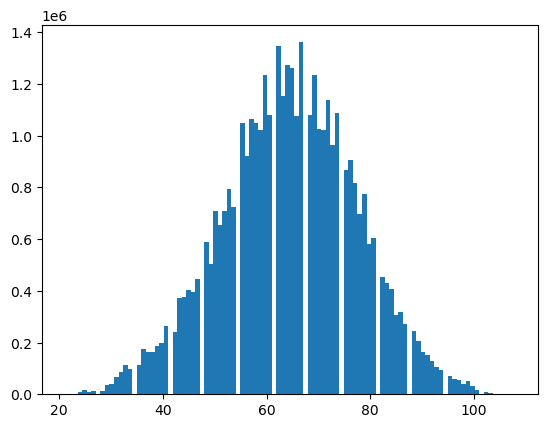

In [44]:
_ = plt.hist(res[..., 0].flatten(), bins=100)

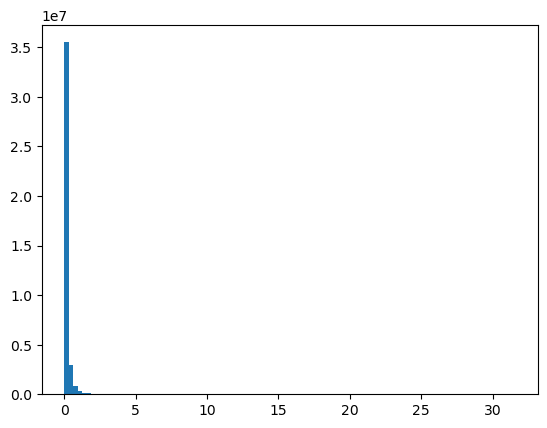

In [45]:
_ = plt.hist(res[..., 1].flatten(), bins=100)

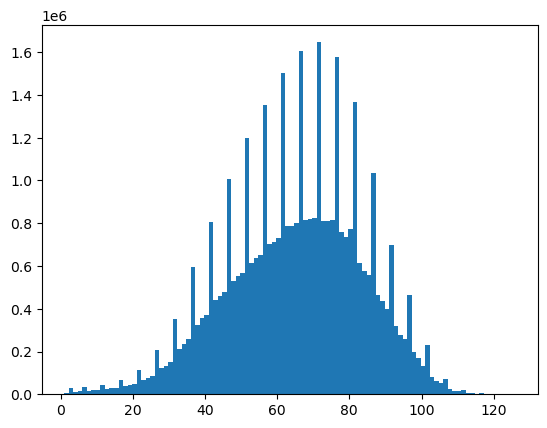

In [46]:
_ = plt.hist(res[..., 2].flatten(), bins=100)

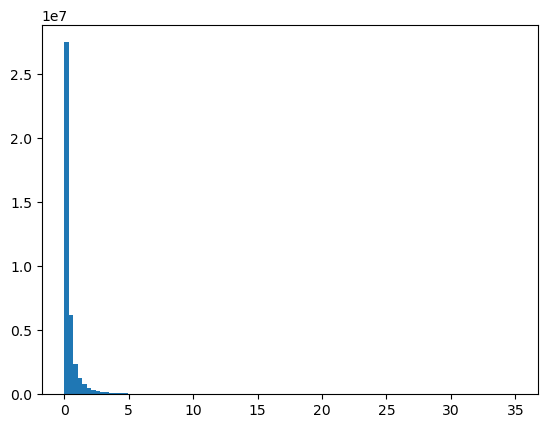

In [47]:
_ = plt.hist(res[..., 3].flatten(), bins=100)

In [48]:
for s in res:
    for n in s:
        if n[1] > 5:
            print(s)

[[ 40.           0.21041666  85.           0.16666667]
 [ 47.           0.13645834  85.           0.10625   ]
 [ 52.           0.053125    82.           0.83229166]
 [ 52.           0.13854167  85.           0.171875  ]
 [ 47.           0.18854167  81.           0.18125   ]
 [ 40.           0.05416667  87.           3.0604167 ]
 [ 41.           0.34583333 105.           0.27916667]
 [ 45.           0.18333334  78.           1.0479167 ]
 [ 41.           0.0375      78.           0.04375   ]
 [ 43.           0.06354167  23.           0.090625  ]
 [ 42.           0.39791667  94.           0.73229164]
 [ 42.           0.771875    98.           1.0614583 ]
 [ 40.           0.43333334  96.           2.4333334 ]
 [ 40.           0.31145832  88.           0.234375  ]
 [ 47.           0.19375     87.           0.153125  ]
 [ 52.           0.06770834  91.           1.05      ]
 [ 33.           0.33541667  97.           0.36145833]
 [ 45.           0.03854167  83.           0.03854167]
 [ 47.    

[[ 68.           0.04427083  85.           0.12369791]
 [ 66.           0.03125     91.           0.3828125 ]
 [ 54.           0.02734375  81.           0.234375  ]
 [ 51.           0.18489583  98.           0.20052083]
 [ 54.           0.07682291  76.           0.05208333]
 [ 56.           0.05859375  71.           1.3632812 ]
 [ 58.           0.15364583  90.           0.3893229 ]
 [ 54.           0.10286459  80.           0.140625  ]
 [ 66.           0.04427083 102.           0.13802083]
 [ 63.           0.0546875   95.           0.2981771 ]
 [ 61.           0.04817708  67.           0.4752604 ]
 [ 63.           0.11458334  85.           3.7265625 ]
 [ 61.           0.10286459  50.           0.5078125 ]
 [ 63.           0.29296875  47.           1.6497396 ]
 [ 61.           0.12890625  54.           0.5859375 ]
 [ 63.           0.4856771   48.           1.8450521 ]
 [ 61.           0.1484375   47.           0.63671875]
 [ 63.           0.40364584  48.           1.9973959 ]
 [ 61.    

[[48.          5.0299478  27.          8.4609375 ]
 [45.          0.03645833 58.          2.579427  ]
 [44.          0.0390625  58.          0.6354167 ]
 [44.          0.03125    70.          1.3242188 ]
 [44.          0.03255208 70.          0.59375   ]
 [44.          0.02994792 77.          0.62890625]
 [44.          0.02864583 75.          4.934896  ]
 [45.          0.02864583 89.          0.953125  ]
 [32.          0.3450521  71.          0.32421875]
 [31.          0.33854166 75.          0.3033854 ]
 [42.          0.19921875 77.          0.3216146 ]
 [29.          0.3059896  75.          0.26953125]
 [42.          0.05598958 66.          0.31510416]
 [40.          0.58463544 56.          0.59375   ]
 [49.          0.04296875 59.          0.3268229 ]
 [42.          0.03776042 72.          0.3046875 ]
 [41.          0.04817708 51.          0.31510416]
 [42.          0.04296875 84.          0.19010417]
 [42.          0.03515625 60.          0.10416666]
 [44.          0.04947917 81.  

[[43.          2.7802083  32.          3.3927083 ]
 [43.          0.08854166 31.          0.31041667]
 [43.          2.640625   30.          3.5760417 ]
 [43.          0.0875     33.          0.29895833]
 [43.          3.0322917  32.          3.54375   ]
 [43.          0.08020833 28.          0.27604166]
 [43.          0.17916666 32.          3.7395833 ]
 [43.          2.8947916  64.          3.346875  ]
 [43.          0.159375   64.          0.26041666]
 [43.          3.1354167  53.          3.3322916 ]
 [43.          0.16354166 65.          0.27291667]
 [43.          2.959375   75.          3.5427084 ]
 [43.          0.31875    65.          0.509375  ]
 [43.          6.211458   64.          6.7010417 ]
 [43.          0.31666666 27.          0.60520834]
 [43.          0.21979167 37.          0.5       ]
 [43.          0.228125   28.          0.55      ]
 [43.          0.21354167 21.          0.55      ]
 [43.          0.23125    21.          0.69895834]
 [43.          0.36354166 25.  

[[73.          0.5182292  65.          2.2096355 ]
 [73.          1.4322916  79.          1.6497396 ]
 [73.          0.08203125  8.          0.54557294]
 [74.          0.6666667  91.          2.0963542 ]
 [71.          0.6666667  81.          2.5820312 ]
 [76.          0.02734375 85.          0.07161459]
 [64.          0.24609375 76.          4.8606772 ]
 [70.          0.3815104  77.          1.0520834 ]
 [68.          1.5130209  85.          2.21875   ]
 [68.          0.76171875 87.          1.1640625 ]
 [71.          0.49609375 82.          1.1471354 ]
 [70.          2.798177   86.          2.7695312 ]
 [58.          0.17057292 76.          0.09114584]
 [61.          0.86067706 70.          1.7864584 ]
 [63.          0.13671875 89.          0.10416666]
 [69.          1.1145834  87.          5.6835938 ]
 [62.          1.2200521  44.          2.0260417 ]
 [58.          0.9036458  55.          2.6692708 ]
 [59.          2.983073   50.          4.2408853 ]
 [58.          5.0390625  32.  

[[44.          1.0651041  42.          1.2669271 ]
 [45.          1.7018229  38.          3.4414062 ]
 [45.          0.60026044 35.          0.88671875]
 [45.          0.3203125  30.          0.73307294]
 [47.          1.1549479  35.          1.4153646 ]
 [47.          2.4192708  35.          3.373698  ]
 [48.          0.3828125  31.          0.70182294]
 [48.          0.34114584 32.          0.66015625]
 [50.          1.6145834  34.          2.0039062 ]
 [50.          1.0208334  28.          0.8697917 ]
 [51.          1.4869791  41.          2.5390625 ]
 [52.          1.09375    46.          1.7213541 ]
 [45.          3.5195312  29.          3.9596355 ]
 [46.          0.5546875  33.          0.91015625]
 [47.          0.3294271  34.          1.1106771 ]
 [55.          0.58463544 33.          0.94661456]
 [55.          0.59375    26.          1.1666666 ]
 [56.          0.3138021  25.          3.7903645 ]
 [55.          1.7942709  26.          3.0091145 ]
 [54.          5.6158853  29.  

[[72.          0.36197916 49.          0.8541667 ]
 [76.          0.3528646  62.          0.8229167 ]
 [72.          0.3294271  58.          0.8229167 ]
 [75.          0.3671875  55.          0.33333334]
 [69.          0.06770834 44.          0.4830729 ]
 [74.          0.34765625 69.          0.30989584]
 [75.          0.08203125 60.          0.52734375]
 [74.          0.3606771  71.          0.30729166]
 [73.          0.08333334 61.          0.5390625 ]
 [74.          0.33854166 60.          0.2981771 ]
 [75.          0.09895834 59.          1.4101562 ]
 [72.          0.45052084 62.          0.3893229 ]
 [73.          0.15104167 55.          0.5104167 ]
 [72.          0.4205729  61.          0.36458334]
 [74.          0.11458334 60.          0.59765625]
 [72.          0.484375   54.          0.9270833 ]
 [72.          0.4934896  75.          1.1848959 ]
 [72.          1.1914062  81.          2.1002605 ]
 [71.          1.0872396  63.          1.7942709 ]
 [71.          5.9960938  49.  

[[ 44.           0.08333334  39.           0.08020833]
 [ 41.           0.046875    75.           0.103125  ]
 [ 49.           0.071875    93.           0.071875  ]
 [ 37.           0.06145833 106.           3.6854167 ]
 [ 45.           0.68125     26.           1.3125    ]
 [ 45.           3.609375    30.           3.8114583 ]
 [ 45.           0.73541665  32.           1.2875    ]
 [ 45.           4.340625    24.           4.4020834 ]
 [ 50.           2.1541667   29.           2.2083333 ]
 [ 45.           1.3427083   23.           4.647917  ]
 [ 52.           0.26145834  29.           0.503125  ]
 [ 50.           0.26770833  26.           0.63854164]
 [ 54.           0.22291666  43.           0.32395834]
 [ 53.           0.309375    42.           0.5625    ]
 [ 52.           0.22083333  48.           0.43645832]
 [ 50.           0.240625    35.           0.7239583 ]
 [ 54.           0.353125    40.           0.41145834]
 [ 49.           0.84270835  37.           4.842708  ]
 [ 45.    

[[60.          2.0958333  64.          2.70625   ]
 [58.          0.696875   41.          1.2458333 ]
 [59.          0.353125   63.          0.60520834]
 [59.          0.35625    69.          3.40625   ]
 [60.          0.73333335 50.          0.6145833 ]
 [59.          0.41770834 49.          0.33333334]
 [60.          0.42708334 56.          0.31145832]
 [59.          0.35625    67.          0.30520833]
 [60.          0.43229166 60.          0.43854168]
 [62.          0.32916668 49.          0.68541664]
 [60.          0.31875    47.          0.24895833]
 [58.          1.4947916  47.          3.10625   ]
 [58.          0.540625   33.          1.3       ]
 [65.          0.44166666 54.          0.640625  ]
 [65.          0.290625   54.          0.8677083 ]
 [63.          2.1364584  49.          1.3739583 ]
 [67.          0.81041664 46.          1.5541667 ]
 [63.          2.5229166  35.          3.0864584 ]
 [62.          1.1989583  32.          3.2729166 ]
 [65.          5.5447917  40.  

[[58.          0.07421875 48.          0.05338542]
 [72.          0.20703125 66.          0.2421875 ]
 [58.          0.09765625 50.          1.4895834 ]
 [63.          0.2565104  35.          0.2421875 ]
 [55.          0.3893229  45.          0.4309896 ]
 [63.          0.3658854  48.          2.0117188 ]
 [58.          5.440104   45.          6.4179688 ]
 [66.          0.03776042 67.          1.3880209 ]
 [61.          0.12239584 42.          0.48828125]
 [61.          0.12630208 39.          0.50130206]
 [61.          0.06770834 51.          0.45572916]
 [63.          0.26171875 53.          0.9817708 ]
 [65.          0.05989583 65.          0.11979166]
 [66.          0.07942709 75.          0.10546875]
 [69.          0.34114584 79.          0.5963542 ]
 [65.          0.16927083 44.          0.44010416]
 [65.          0.12369791 43.          0.4283854 ]
 [65.          0.2643229  43.          0.5260417 ]
 [65.          0.14453125 49.          0.33984375]
 [65.          0.32291666 56.  

[[45.          0.64973956 61.          0.5755208 ]
 [44.          0.15104167 57.          0.5703125 ]
 [43.          0.5286458  56.          0.5651042 ]
 [51.          0.22005208 65.          0.22135417]
 [48.          0.29427084 57.          0.2669271 ]
 [46.          0.06119792 59.          0.47395834]
 [46.          0.04427083 87.          0.26171875]
 [46.          0.0390625  70.          0.19661458]
 [46.          0.0390625  73.          0.6432292 ]
 [48.          0.20963542 60.          0.16927083]
 [46.          0.04817708 69.          0.38020834]
 [46.          0.04036458 65.          0.3997396 ]
 [51.          0.03515625 65.          1.1979166 ]
 [51.          0.06380209 51.          0.18098958]
 [48.          0.05078125 55.          0.3997396 ]
 [46.          0.296875   53.          0.23177083]
 [43.          0.265625   46.          0.23567708]
 [39.          0.046875   58.          0.55598956]
 [46.          0.04427083 44.          0.86588544]
 [46.          5.3125     35.  

[[58.          0.06458333 37.          0.10833333]
 [54.          0.12708333 29.          0.18229167]
 [58.          0.05416667 23.          0.74791664]
 [54.          0.08125    44.          0.13229166]
 [58.          0.05208333 43.          0.73854166]
 [54.          0.09583333 42.          0.115625  ]
 [58.          0.0625     42.          0.32291666]
 [58.          0.09895834 24.          0.128125  ]
 [54.          0.07395833 18.          0.303125  ]
 [54.          1.1416667  24.          1.45      ]
 [49.          0.14166667 33.          0.16458334]
 [46.          0.09791667 37.          0.41875   ]
 [46.          0.15416667 34.          0.16354166]
 [42.          0.240625   32.          0.23645833]
 [46.          0.21770833 38.          0.965625  ]
 [46.          0.38333333 36.          0.271875  ]
 [42.          0.3625     39.          0.35104167]
 [37.          0.41458333 33.          0.378125  ]
 [42.          1.5322917  33.          3.434375  ]
 [42.          5.5125     34.  

[[55.          0.3671875  38.          0.578125  ]
 [55.          0.2799479  39.          0.73046875]
 [55.          0.3984375  48.          0.5989583 ]
 [55.          0.46875    56.          0.6848958 ]
 [55.          0.29947916 63.          0.75130206]
 [56.          0.5833333  54.          0.75390625]
 [56.          0.4986979  61.          0.81901044]
 [56.          0.8333333  74.          1.7408854 ]
 [57.          0.75390625 48.          1.3164062 ]
 [57.          0.26822916 33.          0.7604167 ]
 [57.          0.28385416 29.          0.93359375]
 [55.          0.3997396  34.          0.72526044]
 [55.          0.5104167  34.          0.70442706]
 [55.          0.7526042  22.          2.5664062 ]
 [55.          0.4518229  27.          0.86848956]
 [55.          0.41145834 29.          0.71484375]
 [55.          0.43359375 35.          0.640625  ]
 [55.          0.4466146  35.          0.6822917 ]
 [55.          0.85807294 38.          1.1223959 ]
 [57.          5.1731772  28.  

[[55.          0.4296875  32.          0.60286456]
 [55.          0.4622396  42.          0.609375  ]
 [55.          0.58984375 53.          0.87630206]
 [57.          0.578125   50.          0.7942708 ]
 [57.          0.4296875  32.          0.5677083 ]
 [57.          0.38802084 53.          0.59244794]
 [55.          0.484375   65.          0.59765625]
 [55.          0.43489584 57.          0.609375  ]
 [55.          0.21744792 55.          1.4921875 ]
 [54.          0.4609375  56.          0.75651044]
 [54.          0.15625    55.          1.0559896 ]
 [53.          2.1640625  49.          3.186198  ]
 [52.          1.1601562  29.          3.0846355 ]
 [55.          0.09765625 50.          3.9036458 ]
 [54.          2.1302083  30.          3.1940105 ]
 [53.          2.279948   41.          6.4075522 ]
 [52.          1.2526041  35.          2.2161458 ]
 [55.          2.3046875  34.          3.3372395 ]
 [53.          1.2682291  40.          3.1067708 ]
 [52.          5.8945312  28.  

[[67.          0.371875   24.          0.359375  ]
 [82.          0.4875     69.          0.43958333]
 [68.          0.68958336 33.          0.496875  ]
 [79.          1.5239583  54.          3.265625  ]
 [79.          0.44166666 73.          0.35833332]
 [78.          0.35104167 76.          0.30104166]
 [77.          0.33125    78.          0.28229168]
 [78.          0.49166667 73.          0.4375    ]
 [81.          0.59270835 66.          0.5385417 ]
 [79.          0.42083332 56.          0.36354166]
 [75.          0.40833333 53.          0.60833335]
 [75.          1.6979166  41.          1.5677084 ]
 [74.          0.3625     47.          0.30625   ]
 [77.          0.6125     54.          0.50625   ]
 [75.          0.43958333 50.          0.37083334]
 [74.          0.421875   54.          0.73125   ]
 [74.          1.1770834  42.          3.3104167 ]
 [72.          2.6552083  67.          2.3166666 ]
 [67.          1.1510416  63.          1.        ]
 [70.          6.50625    80.  

[[54.          0.10807291 53.          0.16276042]
 [57.          0.60546875 68.          1.0716146 ]
 [57.          0.07161459 56.          0.75911456]
 [57.          5.263021   66.          7.328125  ]
 [57.          0.8125     38.          1.8554688 ]
 [57.          0.05989583 56.          0.7057292 ]
 [57.          4.1627603  60.          7.5403647 ]
 [59.          0.12890625 50.          0.8541667 ]
 [61.          0.08723959 78.          0.8541667 ]
 [64.          0.06119792 80.          1.1861979 ]
 [63.          0.02994792 86.          0.26041666]
 [66.          0.03515625 95.          0.5130208 ]
 [68.          0.66536456 86.          3.5690105 ]
 [70.          0.03125    96.          0.13802083]
 [66.          0.02864583 88.          0.13541667]
 [70.          0.04427083 96.          0.13541667]
 [66.          0.03255208 90.          0.07552084]
 [62.          0.06640625 94.          0.05078125]
 [63.          0.03125    79.          0.08333334]
 [59.          0.07291666 90.  

[[85.          0.02864583 55.          1.3138021 ]
 [68.          0.02864583 52.          0.06901041]
 [77.          0.04947917 52.          1.4778646 ]
 [67.          0.09505209 41.          0.19140625]
 [70.          0.109375   45.          2.7734375 ]
 [82.          0.18098958 59.          0.15494792]
 [72.          0.10546875 32.          1.3164062 ]
 [77.          0.11197916 32.          0.1328125 ]
 [70.          0.11197916 40.          1.2838541 ]
 [75.          0.05078125 41.          0.06901041]
 [68.          0.13932292 46.          1.6471354 ]
 [73.          0.07942709 38.          0.07552084]
 [77.          0.17447917 49.          0.11848959]
 [84.          0.21354167 49.          1.59375   ]
 [72.          0.48046875 34.          2.2317708 ]
 [70.          0.64453125 38.          2.9479167 ]
 [70.          0.5026042  32.          1.6523438 ]
 [65.          0.75390625 48.          1.9401041 ]
 [70.          2.532552   48.          3.782552  ]
 [68.          8.1328125  40.  

[[79.          5.3294272  89.          8.9869795 ]
 [71.          0.45703125 39.          0.45833334]
 [72.          0.16536458 56.          0.18098958]
 [74.          0.29947916 54.          0.72786456]
 [74.          0.28645834 59.          0.6901042 ]
 [74.          0.29296875 65.          0.7421875 ]
 [72.          0.62369794 67.          0.55598956]
 [74.          0.296875   73.          0.22786458]
 [75.          1.2356771  73.          1.1627604 ]
 [74.          0.40364584 53.          0.4049479 ]
 [72.          0.32291666 57.          0.77473956]
 [74.          0.55859375 66.          0.5364583 ]
 [72.          0.21354167 64.          0.20833333]
 [71.          0.9114583  66.          0.7473958 ]
 [69.          0.609375   63.          0.59244794]
 [71.          0.22526042 63.          0.203125  ]
 [72.          0.97265625 64.          0.9088542 ]
 [74.          0.9869792  58.          0.95963544]
 [75.          0.27083334 55.          0.29166666]
 [74.          1.4518229  51.  

[[71.          2.4960938  56.          3.328125  ]
 [71.          0.69401044 37.          0.69921875]
 [69.          0.21614583 41.          0.5807292 ]
 [68.          1.8867188  40.          3.3320312 ]
 [65.          0.23958333 61.          0.4609375 ]
 [66.          0.13802083 66.          0.14192708]
 [68.          0.05338542 72.          0.15234375]
 [69.          0.22135417 62.          0.5859375 ]
 [66.          0.52994794 55.          0.8046875 ]
 [69.          0.6328125  66.          0.5703125 ]
 [71.          0.41796875 68.          0.37109375]
 [69.          0.2890625  56.          0.8802083 ]
 [69.          0.58203125 43.          0.6432292 ]
 [73.          0.23828125 55.          0.78125   ]
 [74.          1.8346354  51.          1.765625  ]
 [78.          0.17317708 55.          0.4127604 ]
 [78.          1.5065104  66.          1.4466146 ]
 [74.          0.234375   52.          0.5234375 ]
 [74.          3.1835938  54.          4.2395835 ]
 [71.          5.2252603  45.  

[[55.          1.0963541  62.          1.3268229 ]
 [55.          1.7369791  38.          2.1640625 ]
 [55.          0.2591146  48.          0.80598956]
 [54.          0.88932294 42.          1.3671875 ]
 [54.          1.8320312  38.          2.2578125 ]
 [54.          0.625      14.          0.68098956]
 [54.          0.63151044  6.          3.3190105 ]
 [57.          0.3828125  40.          0.7291667 ]
 [56.          2.9765625  38.          3.485677  ]
 [56.          0.10416666 44.          0.76171875]
 [55.          1.0481771  67.          1.0039062 ]
 [63.          0.06640625 60.          0.328125  ]
 [55.          1.7643229  41.          2.0052083 ]
 [55.          0.171875   52.          0.69401044]
 [54.          0.9817708  46.          1.2942709 ]
 [54.          1.9479166  40.          2.329427  ]
 [54.          0.4908854  47.          1.0182291 ]
 [54.          0.8385417  32.          3.404948  ]
 [57.          0.4921875  42.          1.0638021 ]
 [56.          8.207031   37.  

[[56.          0.4830729  55.          0.92317706]
 [55.          1.0872396  35.          1.5572916 ]
 [55.          1.7083334  31.          2.734375  ]
 [55.          0.453125   41.          0.8567708 ]
 [54.          1.2135416  41.          1.6966146 ]
 [54.          1.7630209  34.          2.5872395 ]
 [54.          0.4609375  44.          0.81119794]
 [54.          0.31640625 35.          3.7083333 ]
 [56.          0.5390625  44.          0.7708333 ]
 [56.          3.2460938  41.          3.6783855 ]
 [56.          0.4596354  48.          0.98307294]
 [55.          1.3203125  55.          1.6184896 ]
 [55.          2.204427   32.          2.5755208 ]
 [55.          0.63151044 45.          1.0520834 ]
 [54.          1.3554688  44.          1.7916666 ]
 [54.          2.4765625  20.          2.7604167 ]
 [54.          0.734375   40.          1.1835938 ]
 [54.          1.2057291  37.          4.252604  ]
 [57.          0.4361979  23.          1.2148438 ]
 [53.          5.703125   33.  

[[66.          0.2669271  55.          0.28645834]
 [65.          0.44010416 46.          0.4075521 ]
 [66.          1.7083334  44.          1.9882812 ]
 [66.          0.53125    46.          0.7161458 ]
 [66.          0.5182292  48.          0.67057294]
 [66.          1.2239584  61.          5.2617188 ]
 [66.          0.140625   38.          0.41927084]
 [64.          3.203125   31.          4.174479  ]
 [64.          0.5546875  43.          0.8411458 ]
 [64.          0.3828125  34.          1.0117188 ]
 [63.          0.13541667 48.          0.3125    ]
 [63.          1.78125    42.          2.1197917 ]
 [63.          0.12890625 49.          0.81380206]
 [67.          0.96484375 58.          0.99609375]
 [75.          0.19791667 79.          0.2877604 ]
 [72.          1.5260416  59.          2.157552  ]
 [72.          0.32421875 74.          5.1471353 ]
 [73.          0.6328125  65.          1.0403646 ]
 [72.          0.16276042 53.          0.30208334]
 [72.          6.1705728  61.  

[[30.          0.04947917 48.          0.02994792]
 [26.          0.05729167 24.          0.140625  ]
 [30.          0.0546875  48.          0.4609375 ]
 [33.          0.07942709 56.          0.15885417]
 [30.          0.05338542 71.          0.17708333]
 [33.          0.07682291 72.          0.3268229 ]
 [33.          0.08333334 67.          0.3919271 ]
 [33.          0.08203125 77.          0.22526042]
 [26.          0.07942709 54.          0.21354167]
 [30.          0.06901041 63.          0.04427083]
 [26.          0.04036458 36.          0.15234375]
 [30.          0.05859375 72.          0.16927083]
 [30.          0.04296875 64.          0.16796875]
 [33.          0.09244791 76.          0.1796875 ]
 [30.          0.07942709 78.          0.23828125]
 [30.          0.13671875 69.          0.4596354 ]
 [33.          0.09505209 64.          0.20052083]
 [33.          0.08072916 63.          0.8984375 ]
 [33.          0.07942709 45.          0.55859375]
 [38.          8.454427   85.  

[[39.          5.259375   83.          6.159375  ]
 [44.          0.43854168 49.          0.42916667]
 [39.          0.178125   49.          0.23958333]
 [44.          0.265625   48.          0.29375   ]
 [36.          0.29583332 36.          0.328125  ]
 [39.          0.48020834 44.          0.91041666]
 [36.          1.3239583  33.          1.9760417 ]
 [44.          0.396875   48.          1.29375   ]
 [40.          1.34375    32.          1.896875  ]
 [46.          0.33645833 51.          1.2041667 ]
 [42.          1.6958333  45.          1.7489583 ]
 [51.          0.70520836 60.          1.4739584 ]
 [47.          0.5552083  44.          1.4354167 ]
 [49.          0.559375   52.          1.4322916 ]
 [50.          0.5104167  68.          1.4052083 ]
 [48.          0.19166666 73.          0.13958333]
 [51.          0.20520833 82.          0.13541667]
 [54.          0.80104166 83.          0.71979165]
 [60.          0.1875     80.          0.15625   ]
 [57.          0.240625   90.  

[[68.          0.5        76.          2.001302  ]
 [67.          0.43489584 77.          0.3828125 ]
 [65.          0.4140625  78.          0.33984375]
 [61.          0.19661458 63.          0.14453125]
 [63.          0.07552084 73.          0.18098958]
 [63.          0.51171875 74.          2.0026042 ]
 [63.          0.2565104  59.          0.8776042 ]
 [67.          6.674479   46.          8.947917  ]
 [67.          0.3033854  23.          0.48697916]
 [67.          0.140625   39.          0.7708333 ]
 [67.          0.12369791 53.          0.31510416]
 [64.          0.23177083 35.          0.7578125 ]
 [65.          0.15234375 38.          0.296875  ]
 [69.          0.44010416 59.          0.640625  ]
 [69.          0.16015625 48.          0.31510416]
 [69.          0.19791667 59.          0.14973958]
 [72.          0.1171875  76.          0.609375  ]
 [70.          0.17578125 60.          0.27734375]
 [70.          0.05078125 60.          0.45572916]
 [76.          0.4466146  75.  

[[33.          0.38802084 72.          0.8567708 ]
 [30.          0.30729166 78.          0.25390625]
 [32.          0.05989583 33.          0.8489583 ]
 [32.          0.203125   68.          0.37109375]
 [33.          0.15494792 76.          0.3515625 ]
 [35.          0.49609375 69.          0.46354166]
 [44.          0.31640625 73.          1.5442709 ]
 [33.          0.13541667 72.          0.37890625]
 [37.          0.1796875  68.          0.4778646 ]
 [32.          0.390625   75.          1.5625    ]
 [33.          0.15104167 75.          0.359375  ]
 [38.          0.20963542 73.          0.44140625]
 [35.          0.18489583 73.          0.34895834]
 [32.          0.18619792 74.          0.328125  ]
 [33.          0.2109375  76.          0.37109375]
 [35.          0.1640625  78.          0.3971354 ]
 [37.          0.18619792 65.          0.3684896 ]
 [33.          0.52213544 75.          0.49479166]
 [44.          1.1184896  76.          1.7018229 ]
 [30.          5.9804688  69.  

[[ 43.           1.0078125   33.           3.515625  ]
 [ 43.           0.43359375  78.           3.3411458 ]
 [ 50.           0.3580729   73.           1.7825521 ]
 [ 49.           0.9765625   57.           1.953125  ]
 [ 48.           0.6901042   82.           2.1054688 ]
 [ 47.           0.8333333   40.           2.3216145 ]
 [ 46.           2.421875    87.           3.6028645 ]
 [ 45.           0.82682294  41.           1.7994791 ]
 [ 43.           0.6692708   35.           2.404948  ]
 [ 42.           2.561198    30.           4.6302085 ]
 [ 47.           2.5390625   95.           3.3697917 ]
 [ 43.           0.05078125 106.           3.3177083 ]
 [ 43.           0.17708333  85.           3.9479167 ]
 [ 52.           3.0898438   40.           5.1354165 ]
 [ 45.           3.0182292   21.           4.4440103 ]
 [ 42.           2.923177    31.           4.1236978 ]
 [ 43.           2.6471355   29.           3.9309895 ]
 [ 43.           0.05598958  97.           4.9752603 ]
 [ 43.    

[[ 66.           3.235677    78.           4.4231772 ]
 [ 66.           2.4804688   87.           3.6002605 ]
 [ 66.           2.9140625   60.           4.2239585 ]
 [ 66.           2.6653645   43.           4.6197915 ]
 [ 59.           2.5742188   89.           3.3723958 ]
 [ 58.           1.2239584  100.           3.3046875 ]
 [ 58.           0.32421875  98.           3.920573  ]
 [ 64.           3.6223958   53.           2.2617188 ]
 [ 61.           1.4322916   30.           2.8945312 ]
 [ 57.           2.1132812   36.           2.1341145 ]
 [ 62.           1.          43.           2.3229167 ]
 [ 62.           2.3854167   37.           4.1158853 ]
 [ 62.           2.8203125   43.           4.8359375 ]
 [ 63.           0.09114584 100.           4.059896  ]
 [ 60.           2.2565105   44.           3.4557292 ]
 [ 58.           1.5703125   44.           2.141927  ]
 [ 59.           1.1692709   40.           1.7526041 ]
 [ 55.           1.1419271   40.           1.9010416 ]
 [ 59.    

[[67.          1.2981771  64.          1.6875    ]
 [69.          1.9791666  68.          1.6927084 ]
 [66.          1.4114584  63.          1.6145834 ]
 [66.          1.0117188  43.          2.1666667 ]
 [67.          0.16015625 57.          0.38020834]
 [67.          2.1809895  55.          2.0403645 ]
 [70.          2.140625   75.          1.9492188 ]
 [69.          1.1979166  49.          1.2552084 ]
 [61.          0.23828125 41.          0.17578125]
 [69.          0.14192708 66.          0.26171875]
 [69.          5.40625    73.          4.6341147 ]
 [62.          1.6341146  31.          1.5117188 ]
 [59.          0.15625    45.          2.5533855 ]
 [62.          1.4986979  25.          1.5260416 ]
 [69.          0.13151042 46.          0.34635416]
 [69.          0.69661456 37.          0.64713544]
 [57.          0.28515625 27.          1.7083334 ]
 [62.          3.2851562  24.          4.6210938 ]
 [62.          0.8229167  58.          1.1731771 ]
 [64.          2.1914062  59.  

[[ 32.           0.0390625   99.           0.43489584]
 [ 39.           0.10416666  37.           4.3789062 ]
 [ 34.           0.06510416  96.           0.0390625 ]
 [ 37.           0.046875    54.           2.2135417 ]
 [ 29.           0.03255208 101.           2.7864583 ]
 [ 34.           0.41796875  91.           0.71484375]
 [ 38.           0.15234375  87.           1.4830729 ]
 [ 30.           0.06119792  73.           1.0091146 ]
 [ 31.           0.04166667  79.           1.1015625 ]
 [ 32.           0.06770834  99.           0.06510416]
 [ 34.           0.05208333  34.           2.234375  ]
 [ 32.           0.03776042 109.           2.59375   ]
 [ 32.           0.0546875   97.           1.2421875 ]
 [ 37.           0.22265625  90.           5.1861978 ]
 [ 38.           0.05078125  88.           0.13020833]
 [ 38.           0.29296875  86.           0.81119794]
 [ 32.           0.04817708  96.           0.12630208]
 [ 32.           0.33072916  97.           1.0716146 ]
 [ 26.    

[[50.          0.33854166 74.          0.3203125 ]
 [52.          0.3125     69.          0.3372396 ]
 [50.          0.31640625 45.          0.35546875]
 [48.          0.3268229  52.          0.3502604 ]
 [50.          0.23046875 43.          0.3346354 ]
 [48.          0.1015625  47.          0.35416666]
 [36.          0.05859375 71.          0.35416666]
 [38.          0.05338542 79.          0.36328125]
 [40.          0.07291666 76.          0.34765625]
 [41.          0.09244791 87.          0.3515625 ]
 [45.          0.05859375 86.          0.33333334]
 [46.          0.08723959 85.          2.7695312 ]
 [45.          0.03776042 83.          0.3346354 ]
 [48.          0.05208333 72.          0.08333334]
 [47.          0.05729167 64.          0.08723959]
 [45.          0.09505209 69.          0.13541667]
 [48.          5.59375    84.          5.8450522 ]
 [36.          0.08333334 70.          0.36197916]
 [38.          0.09505209 68.          0.3502604 ]
 [40.          0.13802083 67.  

[[50.          0.38671875 42.          0.625     ]
 [50.          0.20182292 47.          0.84765625]
 [50.          0.64973956 14.          1.2695312 ]
 [50.          0.5807292  24.          1.4557291 ]
 [51.          0.7213542  36.          1.2460938 ]
 [51.          0.34375    36.          0.64973956]
 [51.          0.16276042 42.          4.736979  ]
 [50.          0.55859375 18.          1.3111979 ]
 [53.          0.27604166 41.          0.6432292 ]
 [53.          0.21744792 54.          1.        ]
 [51.          2.264323   47.          3.358073  ]
 [51.          3.6614583  38.          4.1341147 ]
 [50.          1.484375   37.          3.921875  ]
 [53.          0.59375    30.          1.4166666 ]
 [55.          0.4296875  33.          0.72005206]
 [55.          0.30989584 26.          0.99088544]
 [55.          2.3229167  30.          3.4882812 ]
 [53.          2.9947917  32.          3.9023438 ]
 [53.          1.703125   24.          3.3346355 ]
 [53.          5.3424478  43.  

[[52.          0.44140625 70.          0.3984375 ]
 [54.          0.4934896  70.          0.4049479 ]
 [55.          0.4361979  58.          0.4127604 ]
 [54.          0.3763021  47.          0.3815104 ]
 [55.          0.40364584 55.          0.36328125]
 [48.          0.3997396  49.          0.39583334]
 [47.          0.41796875 50.          0.4075521 ]
 [48.          0.37890625 50.          0.37890625]
 [50.          0.40104166 49.          0.3919271 ]
 [48.          0.421875   41.          0.3828125 ]
 [50.          0.14322917 42.          0.50130206]
 [52.          1.2096354  44.          1.1679688 ]
 [54.          1.0286459  58.          1.5481771 ]
 [57.          0.421875   67.          0.3736979 ]
 [59.          0.4049479  66.          1.5976562 ]
 [54.          1.5638021  69.          1.5247396 ]
 [50.          0.39583334 55.          0.3763021 ]
 [47.          0.5260417  61.          2.0338542 ]
 [49.          0.0625     16.          0.765625  ]
 [50.          6.7200522  61.  

[[53.          0.3125     51.          1.4401041 ]
 [54.          0.34375    46.          1.4882812 ]
 [54.          0.26822916 40.          2.7460938 ]
 [50.          0.52994794 48.          0.5026042 ]
 [51.          1.3020834  44.          2.3671875 ]
 [49.          0.47135416 32.          1.5820312 ]
 [49.          0.2669271  43.          1.4440104 ]
 [48.          0.3033854  61.          1.5794271 ]
 [48.          0.26822916 37.          1.6822916 ]
 [49.          2.5533855  39.          2.936198  ]
 [48.          2.358073   51.          2.3528645 ]
 [56.          0.12760417 33.          3.1966145 ]
 [45.          0.0390625  42.          1.1393229 ]
 [39.          0.25       65.          0.2109375 ]
 [37.          0.20963542 63.          0.22135417]
 [36.          0.18359375 61.          0.19921875]
 [34.          0.05598958 64.          0.3359375 ]
 [33.          0.7135417  60.          0.69921875]
 [44.          0.06510416 52.          2.2161458 ]
 [42.          8.707031   50.  

[[48.          0.08723959 69.          0.8046875 ]
 [43.          6.1783853  85.          9.1901045 ]
 [49.          0.55598956 66.          0.99348956]
 [45.          0.22135417 48.          0.2825521 ]
 [50.          0.03645833 59.          0.88151044]
 [44.          0.03515625 58.          0.30208334]
 [41.          0.19921875 65.          1.5065104 ]
 [45.          0.13802083 71.          0.1953125 ]
 [50.          1.5716146  63.          5.7916665 ]
 [52.          0.07682291 50.          0.09505209]
 [50.          0.10677084 57.          0.12369791]
 [48.          0.04036458 46.          0.0390625 ]
 [47.          0.13020833 67.          0.14583333]
 [49.          0.12109375 59.          0.09895834]
 [51.          0.23828125 90.          0.76171875]
 [52.          0.11328125 32.          0.09375   ]
 [50.          0.09114584 54.          0.09895834]
 [49.          0.12890625 70.          0.13151042]
 [47.          0.11979166 66.          0.11458334]
 [45.          0.125      76.  

[[50.          1.2018229  40.          3.6328125 ]
 [50.          0.65625    48.          0.6536458 ]
 [59.          0.2421875  49.          0.7526042 ]
 [48.          6.9440103  46.          8.6171875 ]
 [50.          1.9921875  38.          6.9466147 ]
 [53.          3.326823   47.          3.9036458 ]
 [53.          0.9765625  39.          5.4479165 ]
 [52.          0.8072917  66.          0.7421875 ]
 [53.          0.34114584 58.          0.37239584]
 [55.          0.36197916 64.          0.3919271 ]
 [53.          0.8723958  50.          0.85286456]
 [52.          0.4908854  48.          0.4375    ]
 [53.          0.6744792  75.          0.5989583 ]
 [61.          1.7591146  71.          2.3632812 ]
 [57.          1.6809896  33.          3.515625  ]
 [60.          0.25260416 28.          0.6901042 ]
 [60.          0.26171875 19.          0.66796875]
 [58.          0.07942709 39.          2.8411458 ]
 [64.          0.03776042 36.          1.0325521 ]
 [57.          0.90625    29.  

[[ 71.           0.16536458  49.           0.921875  ]
 [ 76.           0.10807291  76.           1.1197916 ]
 [ 76.           0.09635416  77.           0.13932292]
 [ 71.           0.10026041  70.           0.14322917]
 [ 79.           0.09505209  78.           1.1796875 ]
 [ 71.           0.15234375  80.           0.30989584]
 [ 71.           0.12760417  57.           0.3268229 ]
 [ 71.           0.15364583  80.           0.36197916]
 [ 71.           0.1328125   82.           0.2877604 ]
 [ 76.           0.1171875   93.           0.30208334]
 [ 75.           0.1328125   61.           0.11848959]
 [ 76.           0.05729167  80.           0.1484375 ]
 [ 78.           0.17317708  97.           0.15364583]
 [ 79.           0.06510416  89.           0.19401042]
 [ 82.           0.16145833 103.           0.17708333]
 [ 81.           0.01822917  78.           0.21614583]
 [ 78.           0.05208333  95.           3.889323  ]
 [ 76.           0.04817708  41.           4.2018228 ]
 [ 78.    

[[60.          0.86328125 30.          1.9830729 ]
 [58.          0.54557294 34.          1.3997396 ]
 [60.          0.5026042  46.          1.1809896 ]
 [60.          2.3997395  52.          4.4882812 ]
 [61.          5.9804688  27.          8.647136  ]
 [61.          0.03776042 53.          0.10546875]
 [54.          0.04166667 52.          0.60546875]
 [61.          0.03125    42.          0.19140625]
 [61.          0.03776042 41.          0.6197917 ]
 [61.          0.11328125 81.          0.93359375]
 [62.          0.04036458 40.          0.5833333 ]
 [62.          0.03255208 51.          0.01692708]
 [66.          0.03385417 43.          0.15234375]
 [66.          0.16666667 52.          0.16666667]
 [57.          0.04296875 52.          0.16015625]
 [62.          0.05338542 40.          0.40104166]
 [62.          0.02604167 64.          0.1796875 ]
 [66.          0.13541667 43.          0.15234375]
 [57.          0.04296875 68.          0.12109375]
 [62.          0.04296875 54.  

[[ 54.           0.15625     69.           0.24739583]
 [ 57.           0.16536458  67.           0.18489583]
 [ 54.           0.1796875   67.           0.17838542]
 [ 57.           0.2578125   67.           0.19010417]
 [ 54.           0.22005208  66.           0.18880208]
 [ 57.           0.22395833  66.           0.18619792]
 [ 54.           0.22395833  72.           0.19661458]
 [ 57.           0.22395833  76.           0.1796875 ]
 [ 54.           0.17447917  74.           0.19791667]
 [ 57.           0.06901041  74.           0.2513021 ]
 [ 57.           0.20182292  63.           0.17578125]
 [ 62.           0.20052083  51.           0.1796875 ]
 [ 57.           0.18359375  71.           0.20572917]
 [ 62.           0.20572917  61.           0.18229167]
 [ 66.           0.21875     74.           0.1796875 ]
 [ 69.           0.14453125  76.           0.21484375]
 [ 74.           0.11848959  80.           3.3854167 ]
 [ 69.           0.3736979   94.           0.609375  ]
 [ 69.    

[[68.          0.16276042 48.          0.234375  ]
 [72.          0.21223958 48.          0.4830729 ]
 [72.          0.05078125 48.          0.80078125]
 [68.          0.18880208 43.          0.51171875]
 [68.          0.22005208 49.          0.58984375]
 [68.          0.25260416 33.          0.26302084]
 [61.          0.3346354  42.          0.32291666]
 [65.          0.42708334 41.          0.41666666]
 [68.          0.23567708 44.          0.18098958]
 [61.          0.17057292 41.          0.19010417]
 [65.          0.30859375 25.          0.375     ]
 [68.          1.3072916  50.          1.3346354 ]
 [61.          0.12760417 41.          0.14322917]
 [65.          0.19921875 42.          0.14713542]
 [68.          0.11067709 48.          0.4765625 ]
 [61.          0.12630208 46.          0.1484375 ]
 [65.          0.13151042 43.          0.1328125 ]
 [68.          0.27083334 52.          0.72786456]
 [68.          0.453125   31.          1.4674479 ]
 [68.          7.549479   34.  

[[51.          0.38671875 21.          0.3606771 ]
 [64.          0.2877604  37.          0.9505208 ]
 [55.          0.55598956 14.          1.1080729 ]
 [55.          0.21484375 18.          0.60286456]
 [55.          0.19661458 15.          0.4765625 ]
 [55.          0.1640625  22.          2.0533855 ]
 [52.          0.3059896  27.          0.77734375]
 [52.          0.19921875 23.          0.94401044]
 [52.          0.3828125  24.          0.85286456]
 [52.          0.11848959 25.          0.6223958 ]
 [52.          0.25       33.          0.640625  ]
 [52.          0.09505209  9.          0.60807294]
 [52.          0.2721354  25.          0.70963544]
 [52.          0.12890625 17.          0.69921875]
 [52.          0.34895834 21.          0.9661458 ]
 [52.          0.16276042 21.          1.9440104 ]
 [48.          3.4492188  21.          7.4361978 ]
 [52.          1.0403646  23.          3.5130208 ]
 [51.          2.8463542  35.          6.015625  ]
 [52.         14.6640625   9.  

[[ 65.           9.407552    49.          12.464844  ]
 [ 66.           0.20182292  80.           0.2747396 ]
 [ 67.           0.03645833  80.           0.515625  ]
 [ 67.           0.12109375  87.           0.78776044]
 [ 66.           0.20182292  85.           0.27864584]
 [ 70.           0.13151042  93.           0.79036456]
 [ 70.           0.22395833  98.           0.18880208]
 [ 67.           0.07682291  85.           0.2643229 ]
 [ 69.           0.04947917  76.           0.84375   ]
 [ 72.           0.05729167  80.           0.52994794]
 [ 73.           0.14453125 100.           0.3528646 ]
 [ 72.           0.36458334  78.           0.84765625]
 [ 69.           0.3216146   83.           0.34635416]
 [ 58.           0.05208333  94.           2.8242188 ]
 [ 73.           0.04166667  40.           0.11328125]
 [ 67.           0.06510416  85.           0.63932294]
 [ 78.           0.17578125  88.           0.11979166]
 [ 69.           0.05989583  82.           0.1875    ]
 [ 78.    

[[59.          0.04296875 19.          1.8802084 ]
 [59.          0.6640625  47.          2.7994792 ]
 [58.          0.05598958 59.          0.3736979 ]
 [58.          0.04166667 57.          0.7786458 ]
 [61.          0.20182292 76.          0.2721354 ]
 [56.          0.24739583 63.          0.4205729 ]
 [58.          0.04166667 71.          0.02864583]
 [54.          0.04166667 49.          1.        ]
 [58.          0.11197916 72.          0.11197916]
 [66.          0.10807291 77.          3.0598958 ]
 [61.          0.04036458 44.          0.05989583]
 [66.          0.14713542 71.          0.14322917]
 [70.          0.21223958 79.          0.2721354 ]
 [73.          0.09635416 71.          0.53515625]
 [66.          0.109375   54.          0.13411458]
 [70.          0.28125    64.          1.2408854 ]
 [63.          0.05859375 44.          0.87109375]
 [66.          0.3763021  46.          0.80338544]
 [63.          0.04296875 36.          1.3854166 ]
 [61.          5.0169272  31.  

[[51.          0.6302083  57.          0.55859375]
 [54.          0.58723956 54.          0.54557294]
 [53.          0.6640625  57.          0.54557294]
 [54.          0.64192706 61.          0.56380206]
 [51.          0.87890625 51.          0.5833333 ]
 [53.          0.7760417  52.          0.70963544]
 [54.          1.1132812  56.          1.0625    ]
 [58.          2.0898438  63.          2.0898438 ]
 [59.          1.4179688  47.          2.9023438 ]
 [60.          0.38020834 28.          2.8033855 ]
 [63.          0.5494792  40.          5.1575522 ]
 [66.          0.4075521  67.          0.7005208 ]
 [65.          0.3372396  81.          0.6927083 ]
 [66.          0.453125   85.          0.7369792 ]
 [63.          0.4466146  93.          1.7382812 ]
 [66.          0.38541666 99.          1.4570312 ]
 [65.          2.1445312  95.          3.4752605 ]
 [66.          1.3346354  44.          3.2135417 ]
 [66.          4.9700522  27.          6.341146  ]
 [63.          7.8958335  42.  

[[36.          5.7330728  26.          7.7226562 ]
 [37.          0.11588541 71.          0.13411458]
 [43.          0.140625   78.          0.125     ]
 [36.          0.04817708 83.          0.11067709]
 [52.          0.06640625 86.          0.1171875 ]
 [48.          0.10677084 82.          0.10416666]
 [45.          0.05208333  3.          0.02604167]
 [56.          0.07161459 91.          0.13802083]
 [48.          0.12630208 80.          0.11848959]
 [41.          0.13151042 79.          0.4752604 ]
 [37.          0.07421875 68.          0.17447917]
 [36.          0.04166667 78.          0.11197916]
 [52.          0.12239584 85.          0.12239584]
 [48.          0.11067709 76.          0.11848959]
 [41.          0.20052083 78.          0.21223958]
 [44.          0.1015625  73.          0.10416666]
 [39.          0.09765625 77.          0.16536458]
 [42.          0.06901041 26.          0.07291666]
 [44.          0.11848959 78.          0.11588541]
 [37.          0.02604167 72.  

[[73.          1.0807291  49.          1.7447916 ]
 [72.          1.6367188  53.          2.2630208 ]
 [72.          0.27604166 54.          0.5364583 ]
 [72.          0.19921875 62.          0.5260417 ]
 [72.          0.24479167 59.          0.71484375]
 [72.          7.4752603  52.          8.657552  ]
 [70.          0.3125     69.          0.5625    ]
 [70.          0.4518229  86.          0.453125  ]
 [60.          0.20833333 51.          0.5260417 ]
 [60.          6.5390625  53.          5.9596353 ]
 [67.          1.9856771  55.          1.9114584 ]
 [66.          0.89713544 53.          0.8854167 ]
 [70.          0.42578125 49.          0.34895834]
 [68.          1.296875   53.          1.3502604 ]
 [66.          0.14322917 50.          0.43359375]
 [71.          0.5104167  45.          0.44010416]
 [78.          0.6588542  66.          2.0026042 ]
 [73.          0.4309896  61.          1.1809896 ]
 [79.          0.65625    64.          2.3841145 ]
 [75.          0.05989583 78.  

[[60.          0.54791665 52.          0.49895832]
 [59.          0.42395833 53.          0.41458333]
 [57.          0.41041666 50.          0.38958332]
 [55.          0.15416667 46.          0.18333334]
 [64.          0.23645833 68.          0.25625   ]
 [54.          0.8489583  47.          0.8177083 ]
 [55.          0.51354164 44.          0.46979168]
 [54.          0.41354167 48.          0.40208334]
 [52.          0.38541666 51.          0.38333333]
 [50.          0.46458334 51.          0.42291668]
 [52.          1.1072917  60.          1.09375   ]
 [48.          0.321875   63.          0.29270834]
 [47.          0.225      62.          0.21145834]
 [45.          0.25833333 67.          0.23958333]
 [47.          3.096875   63.          3.734375  ]
 [40.          3.5729167  60.          3.340625  ]
 [47.          0.24791667 74.          0.22083333]
 [44.          0.28229168 78.          0.24166666]
 [47.          0.278125   74.          0.24583334]
 [40.          5.6270833  68.  

[[59.          0.76953125 42.          1.0638021 ]
 [59.          1.0338541  41.          1.2682291 ]
 [59.          0.86067706 40.          1.1315104 ]
 [59.          1.0052084  42.          1.2916666 ]
 [59.          1.4752604  41.          1.8111979 ]
 [59.          3.5416667  35.          7.8190103 ]
 [58.          0.54557294 33.          2.2773438 ]
 [59.          8.259114   35.         12.203125  ]
 [62.          4.372396    3.          4.8229165 ]
 [58.          2.4609375  31.          2.4583333 ]
 [65.          0.7473958  31.          4.278646  ]
 [63.          0.69661456 36.          2.3723958 ]
 [61.          0.78776044 43.          0.85286456]
 [67.          0.98046875 58.          2.1992188 ]
 [62.          1.1484375  41.          1.1263021 ]
 [64.          1.3619791  45.          2.2317708 ]
 [60.          1.171875   26.          1.8932291 ]
 [60.          1.3567709  30.          2.6770833 ]
 [60.          4.0403647  17.          5.25      ]
 [61.          0.07161459 88.  

[[69.          0.49739584 98.          0.9322917 ]
 [71.          0.22135417 91.          0.25260416]
 [60.          0.23828125 93.          2.1302083 ]
 [64.          0.12109375 76.          1.1861979 ]
 [71.          0.32421875 85.          0.51692706]
 [71.          0.4453125  85.          2.1744792 ]
 [71.          1.4934896  71.          1.5221354 ]
 [71.          5.1145835  28.          7.4830728 ]
 [71.          0.21875    53.          0.1796875 ]
 [70.          0.10807291 64.          0.12369791]
 [69.          0.0546875  72.          1.0768229 ]
 [65.          0.20963542 76.          0.453125  ]
 [74.          0.26953125 71.          0.2513021 ]
 [73.          0.12369791 67.          0.20052083]
 [72.          0.15755208 61.          0.19010417]
 [71.          0.12760417 52.          0.19791667]
 [62.          0.05989583 48.          2.7682292 ]
 [65.          0.3203125  57.          0.37760416]
 [61.          0.20963542 51.          0.7161458 ]
 [65.          0.19401042 13.  

[[ 63.           0.08541667  78.           0.14166667]
 [ 59.           0.09166667  76.           0.05416667]
 [ 70.           0.084375    37.           0.084375  ]
 [ 60.           0.08333334  83.           0.05625   ]
 [ 63.           0.06354167  75.           0.08229167]
 [ 61.           0.125       91.           0.14166667]
 [ 62.           0.15520833  85.           0.13958333]
 [ 58.           0.08125     87.           0.075     ]
 [ 68.           0.03020833  78.           0.03645833]
 [ 74.           0.03125     47.           0.09375   ]
 [ 63.           0.03958333  43.           0.025     ]
 [ 68.           0.0625      26.           0.07395833]
 [ 62.           0.10833333  78.           0.07083333]
 [ 70.           0.05        28.           0.31458333]
 [ 63.           0.02708333  47.           0.05      ]
 [ 60.           0.08125     72.           0.12083333]
 [ 61.           0.11875     81.           0.1375    ]
 [ 62.           0.165625    81.           0.14791666]
 [ 58.    

[[ 48.           0.04427083  77.           0.125     ]
 [ 48.           0.08072916  84.           1.1536459 ]
 [ 48.           0.04817708  93.           0.1171875 ]
 [ 48.           0.04557292  84.           2.9570312 ]
 [ 48.           1.0195312   83.           1.4739584 ]
 [ 49.           1.0481771   92.           1.8528646 ]
 [ 50.           0.9427083   86.           2.029948  ]
 [ 54.           4.1158853   81.           4.9010415 ]
 [ 47.           6.0611978   83.          10.7890625 ]
 [ 63.           0.02864583  81.           3.84375   ]
 [ 54.           0.02604167  96.           0.01822917]
 [ 58.           0.02473958  70.           1.0846354 ]
 [ 51.           0.03385417  67.           0.10286459]
 [ 51.           0.05078125  85.           1.4869791 ]
 [ 51.           0.03385417  74.           0.0390625 ]
 [ 54.           0.0546875   39.           0.06770834]
 [ 51.           0.06510416  90.           0.8307292 ]
 [ 36.           0.1328125   76.           0.19270833]
 [ 42.    

[[ 54.           0.2421875  101.           0.7760417 ]
 [ 50.           0.09765625  28.           0.8020833 ]
 [ 48.           0.29296875 106.           1.6315104 ]
 [ 46.           0.28385416 102.           1.6848959 ]
 [ 44.           0.12369791 100.           2.0716145 ]
 [ 42.           0.4518229   96.           5.125     ]
 [ 49.           0.05859375  85.           0.13802083]
 [ 49.           0.99869794  93.           1.8046875 ]
 [ 54.           0.0625      81.           0.13541667]
 [ 54.           1.5651041   89.           1.8828125 ]
 [ 54.           0.80598956  93.           1.6875    ]
 [ 59.           1.5976562   97.           2.0091145 ]
 [ 59.           1.4179688   94.           5.5234375 ]
 [ 57.           0.05598958  85.           0.10416666]
 [ 57.           0.17447917  83.           2.6276042 ]
 [ 57.           1.7226562   73.           2.4596355 ]
 [ 57.           0.03385417  82.           0.10677084]
 [ 57.           1.1041666   93.           1.4127604 ]
 [ 57.    

[[35.          0.04166667 48.          3.3567708 ]
 [29.          0.34635416 60.          1.4453125 ]
 [31.          0.12890625 47.          0.1171875 ]
 [35.          0.04296875 51.          0.83203125]
 [29.          0.17708333 57.          0.13151042]
 [35.          0.05989583 64.          0.09375   ]
 [42.          0.03515625 75.          0.95963544]
 [29.          0.08854166 79.          0.10026041]
 [34.          0.06770834 16.          1.2682291 ]
 [32.          0.09635416 75.          1.2604166 ]
 [29.          0.06119792 68.          1.2486979 ]
 [32.          0.0625     71.          1.5794271 ]
 [29.          0.0546875  45.          0.9010417 ]
 [35.          0.12239584 49.          0.12369791]
 [29.          0.05598958 37.          1.0989584 ]
 [29.          0.19791667 44.          0.5598958 ]
 [38.          0.05338542 34.          0.05598958]
 [32.          0.04557292 48.          0.5963542 ]
 [30.          0.7786458  49.          0.7708333 ]
 [29.          5.6757812  32.  

[[69.          0.19661458 71.          0.15885417]
 [67.          0.06510416 76.          0.18880208]
 [65.          0.21354167 72.          0.16796875]
 [64.          0.1015625  72.          0.39453125]
 [58.          1.4765625  44.          4.268229  ]
 [60.          0.42447916 18.          0.5703125 ]
 [62.          0.2981771  36.          0.46484375]
 [64.          0.23828125 50.          0.44010416]
 [65.          0.2981771  55.          3.7916667 ]
 [65.          0.93098956 52.          0.8541667 ]
 [64.          1.0169271  46.          0.88151044]
 [60.          0.4934896  27.          0.421875  ]
 [58.          0.25260416 34.          5.096354  ]
 [58.          0.33333334 66.          0.55859375]
 [56.          1.2330729  39.          1.6106771 ]
 [58.          2.609375   48.          2.4296875 ]
 [59.          1.0338541  37.          0.88411456]
 [60.          5.263021   42.          5.2513022 ]
 [61.          0.38020834 43.          0.3606771 ]
 [60.          0.33333334 43.  

[[56.          0.14375    61.          0.12395833]
 [58.          0.11145833 81.          0.11145833]
 [60.          0.14270833 84.          0.128125  ]
 [58.          0.13125    83.          0.11458334]
 [56.          0.10416666 82.          0.11770833]
 [55.          0.11770833 70.          0.12291667]
 [58.          0.14270833 75.          0.13333334]
 [63.          0.08958333 76.          0.11875   ]
 [67.          0.090625   67.          0.10416666]
 [65.          0.10729167 70.          0.11145833]
 [63.          0.13333334 74.          0.13125   ]
 [68.          0.50104165 74.          2.9041667 ]
 [58.          0.87291664 72.          3.703125  ]
 [61.          0.15104167 81.          0.353125  ]
 [56.          0.26354167 88.          3.5729167 ]
 [58.          5.359375   58.          6.704167  ]
 [57.          1.7697917  53.          1.9635416 ]
 [53.          0.04895834 50.          0.38333333]
 [53.          0.04583333 54.          0.38541666]
 [53.          0.05208333 50.  

[[68.          0.08854166 44.          0.6354167 ]
 [68.          0.05859375 41.          0.09505209]
 [70.          0.07552084 41.          0.10677084]
 [72.          0.8125     43.          1.4270834 ]
 [70.          0.08463541 39.          0.29427084]
 [68.          0.30078125 40.          0.9270833 ]
 [67.          2.5104167  32.          3.9244792 ]
 [67.          3.561198   39.          3.5117188 ]
 [62.          0.2825521  35.          1.5117188 ]
 [65.          3.595052   41.          4.3372397 ]
 [65.          5.1796875  43.          5.2539062 ]
 [62.          0.25390625 34.          0.88932294]
 [65.          3.6875     34.          4.7877603 ]
 [65.          1.9804688  33.          3.2695312 ]
 [65.          0.15494792 31.          0.8020833 ]
 [65.          0.23046875 36.          0.7057292 ]
 [67.          0.07942709 42.          0.19661458]
 [69.          0.06901041 55.          0.47916666]
 [70.          0.3424479  47.          0.8515625 ]
 [65.          0.19661458 45.  

[[52.          0.04427083 44.          0.17838542]
 [55.          0.05338542 51.          0.06380209]
 [49.          0.07552084 48.          0.11588541]
 [55.          0.03645833 60.          0.07682291]
 [51.          0.03515625 67.          0.046875  ]
 [61.          0.11588541 71.          0.09114584]
 [46.          0.05078125 32.          0.07682291]
 [52.          0.0546875  53.          0.08072916]
 [49.          0.03125    43.          0.03255208]
 [58.          0.12890625 72.          0.14453125]
 [52.          0.06770834 74.          0.12239584]
 [64.          0.11067709 92.          0.08854166]
 [58.          0.0703125  61.          0.07161459]
 [49.          0.08984375 70.          0.125     ]
 [55.          0.06640625 73.          0.04427083]
 [49.          1.1510416  44.          5.5       ]
 [55.          0.4127604  41.          1.2070312 ]
 [53.          1.6966146  39.          3.141927  ]
 [57.          1.0703125  35.          2.8177083 ]
 [57.          8.126302   33.  

[[64.          0.34114584 33.          0.3893229 ]
 [68.          0.21354167 33.          0.3111979 ]
 [64.          0.39322916 40.          5.372396  ]
 [61.          0.45833334 29.          0.44791666]
 [64.          0.3216146  43.          0.3893229 ]
 [69.          0.3033854  42.          0.3346354 ]
 [73.          0.31770834 43.          0.32421875]
 [76.          0.25520834 36.          1.5898438 ]
 [76.          0.46614584 59.          0.40234375]
 [71.          0.34635416 41.          0.37890625]
 [69.          0.4622396  43.          0.49739584]
 [71.          0.68619794 51.          0.73567706]
 [66.          0.92317706 39.          0.984375  ]
 [64.          0.734375   25.          1.6783854 ]
 [64.          1.8893229  37.          3.0078125 ]
 [64.          0.12630208 37.          1.0768229 ]
 [61.          0.07291666 36.          1.0638021 ]
 [61.          0.23177083 24.          1.7122396 ]
 [64.          4.0299478  44.          4.059896  ]
 [56.          5.1145835  52.  

[[74.          3.9416666  53.          4.565625  ]
 [70.          2.2864583  73.          2.1010416 ]
 [69.          0.565625   55.          1.8635417 ]
 [69.          5.6291666  64.          2.8166666 ]
 [74.          3.6114583  49.          4.56875   ]
 [72.          1.028125   59.          0.97291666]
 [68.          0.67291665 71.          0.8854167 ]
 [68.          0.44479167 69.          0.43333334]
 [71.          1.8375     65.          2.1489584 ]
 [69.          1.0010417  56.          2.7291667 ]
 [67.          1.0375     34.          2.184375  ]
 [69.          0.32083333 45.          1.7625    ]
 [72.          0.31666666 56.          0.78333336]
 [74.          0.27291667 72.          0.9947917 ]
 [76.          0.68333334 69.          2.41875   ]
 [77.          1.45625    58.          2.1395833 ]
 [76.          0.653125   42.          2.3427083 ]
 [72.          0.37604168 43.          4.65625   ]
 [72.          1.184375   71.          2.0135417 ]
 [72.          0.88854164 76.  

[[34.          0.39453125 28.          1.34375   ]
 [37.          0.52473956 30.          1.3671875 ]
 [34.          0.390625   28.          1.5091146 ]
 [37.          0.49609375 30.          1.4440104 ]
 [34.          0.4609375  23.          1.4934896 ]
 [37.          0.5989583  21.          2.0494792 ]
 [34.          5.5390625  25.          9.7369795 ]
 [40.          0.08072916 22.          0.23307292]
 [41.          0.06510416 45.          0.14583333]
 [43.          0.06119792 16.          0.04817708]
 [46.          0.06770834 48.          0.10286459]
 [49.          0.04817708 44.          0.9322917 ]
 [42.          0.07161459 37.          0.1484375 ]
 [43.          0.05859375 42.          0.078125  ]
 [45.          0.078125   50.          0.11848959]
 [48.          0.05598958 48.          0.11067709]
 [51.          0.04166667 44.          0.03125   ]
 [42.          0.11588541 52.          0.13020833]
 [45.          0.0703125  42.          0.10807291]
 [46.          0.046875   51.  

[[66.          0.17447917 55.          0.27864584]
 [61.          0.5208333  49.          1.0442709 ]
 [60.          0.13411458 48.          0.28645834]
 [60.          0.17057292 69.          0.890625  ]
 [63.          0.02864583 62.          1.7265625 ]
 [61.          0.28515625 54.          2.2747395 ]
 [61.          0.3919271  70.          2.4335938 ]
 [61.          0.7552083  57.          1.0690104 ]
 [60.          0.89713544 57.          2.9791667 ]
 [60.          0.98567706 28.          1.234375  ]
 [60.          0.89192706 43.          1.2643229 ]
 [56.          0.5677083  43.          2.5403645 ]
 [57.          1.1393229  30.          1.203125  ]
 [57.          1.1653646   8.          4.2408853 ]
 [53.          1.4635416  38.          1.3776041 ]
 [54.          1.1341146  30.          2.8242188 ]
 [54.          0.46614584 29.          1.5416666 ]
 [53.          0.59244794 20.          1.4166666 ]
 [54.          0.5390625  28.          2.0598958 ]
 [53.          5.6497397  23.  

[[ 47.           0.19270833  90.           0.3502604 ]
 [ 43.           0.05729167 101.           0.2513021 ]
 [ 40.           0.18359375  96.           0.16536458]
 [ 52.           0.03125     84.           1.0390625 ]
 [ 40.           0.09244791  90.           0.24479167]
 [ 40.           0.04817708  90.           0.14453125]
 [ 40.           0.0390625   94.           0.11197916]
 [ 40.           0.03776042  96.           1.0859375 ]
 [ 47.           0.04427083 103.           0.08854166]
 [ 47.           0.2799479   76.           0.5234375 ]
 [ 42.           0.02473958 101.           0.9479167 ]
 [ 42.           0.03515625 108.           0.43489584]
 [ 47.           0.04296875 100.           0.74088544]
 [ 47.           0.04036458 101.           0.4140625 ]
 [ 42.           0.02864583 101.           0.046875  ]
 [ 44.           0.00130208  35.           0.41796875]
 [ 47.           0.06770834 108.           2.9348958 ]
 [ 47.           1.9361979  104.           1.9023438 ]
 [ 35.    

[[55.          3.2427084  37.          4.186458  ]
 [52.          0.21770833 46.          0.575     ]
 [53.          4.679167   40.          6.210417  ]
 [52.          0.22291666 41.          0.5833333 ]
 [53.          5.415625   44.          6.8166666 ]
 [52.          0.05       27.          0.20729166]
 [48.          0.05416667 45.          0.03541667]
 [55.          0.03958333 36.          0.15625   ]
 [55.          0.04375    51.          0.18541667]
 [55.          0.03958333 44.          0.16354166]
 [55.          0.04479166 51.          0.17395833]
 [55.          0.046875   49.          0.17291667]
 [55.          0.04583333 52.          0.17395833]
 [55.          0.04583333 51.          0.18645833]
 [55.          0.04583333 50.          0.17083333]
 [55.          0.04791667 53.          0.17708333]
 [55.          0.046875   49.          0.16770834]
 [55.          0.04895834 56.          0.17916666]
 [55.          0.046875   54.          0.165625  ]
 [55.          0.04375    55.  

[[ 61.           0.09765625  93.           0.06380209]
 [ 63.           0.06770834  72.           0.08463541]
 [ 62.           0.08463541  96.           0.06380209]
 [ 67.           0.0625      83.           0.09114584]
 [ 58.           0.0546875   94.           0.05989583]
 [ 74.           0.04036458  63.           0.09635416]
 [ 67.           0.078125    98.           0.04036458]
 [ 70.           0.06901041  85.           0.109375  ]
 [ 62.           0.07682291  98.           0.04947917]
 [ 74.           0.07291666  87.           0.14713542]
 [ 75.           0.07161459  83.           0.17057292]
 [ 63.           0.05338542  74.           0.14583333]
 [ 67.           0.0390625   65.           0.14973958]
 [ 67.           0.02604167  72.           0.06380209]
 [ 68.           0.05338542   2.           0.06510416]
 [ 67.           0.05208333  76.           0.12630208]
 [ 74.           0.04947917  71.           0.328125  ]
 [ 67.           0.03776042  63.           0.2747396 ]
 [ 69.    

[[53.          0.7125     32.          0.70104164]
 [60.          0.05       42.          0.84270835]
 [57.          0.146875   24.          0.325     ]
 [57.          0.06145833 41.          0.903125  ]
 [55.          0.075      38.          0.23125   ]
 [55.          0.07604167 50.          0.46979168]
 [55.          0.27708334 42.          0.25625   ]
 [57.          0.17291667 48.          0.54895836]
 [53.          0.721875   43.          0.7125    ]
 [65.          0.05625    60.          0.58958334]
 [57.          0.04583333 42.          0.70520836]
 [57.          0.0625     35.          0.7395833 ]
 [55.          0.06770834 25.          0.23229167]
 [55.          0.06875    44.          0.25208333]
 [55.          0.10416666 31.          0.2875    ]
 [55.          0.08541667 45.          0.27083334]
 [55.          0.08645833 42.          0.365625  ]
 [57.          0.325      39.          0.45520833]
 [58.          0.18020834 38.          1.8104167 ]
 [58.          5.003125   31.  

[[ 49.           0.11875     73.           0.47916666]
 [ 54.           0.275       76.           0.21145834]
 [ 51.           0.265625    85.           0.21875   ]
 [ 49.           0.09375     84.           0.44479167]
 [ 52.           0.23958333  82.           0.20208333]
 [ 49.           0.15520833  89.           0.68854165]
 [ 52.           0.0375      61.           0.02291667]
 [ 53.           0.040625    40.           0.15729167]
 [ 49.           0.10625     93.           0.62916666]
 [ 51.           0.146875    97.           0.23958333]
 [ 49.           0.1         96.           0.8854167 ]
 [ 51.           0.16145833  98.           0.33958334]
 [ 49.           0.07083333  99.           1.7083334 ]
 [ 49.           6.9583335  101.           6.9083333 ]
 [ 54.           0.08854166  38.           0.35104167]
 [ 49.           0.86354166  37.           0.878125  ]
 [ 54.           0.34479168  42.           0.5072917 ]
 [ 49.           1.328125    26.           1.1979166 ]
 [ 54.    

[[38.          9.544791   96.          9.4875    ]
 [52.          0.33229166 79.          0.35416666]
 [45.          0.21145834 76.          0.13541667]
 [48.          0.25       81.          0.459375  ]
 [50.          0.31666666 69.          0.31354168]
 [58.          0.15833333 80.          0.23333333]
 [67.          0.30625    82.          0.76354164]
 [67.          0.16875    82.          0.20729166]
 [58.          0.13333334 79.          0.09895834]
 [55.          0.16354166 76.          0.096875  ]
 [50.          0.19270833 77.          0.14583333]
 [46.          0.5364583  81.          0.8229167 ]
 [42.          0.47916666 87.          3.1552083 ]
 [57.          0.12395833 71.          0.084375  ]
 [54.          0.08333334 77.          0.07916667]
 [50.          0.16770834 73.          0.16979167]
 [57.          0.11458334 75.          1.2791667 ]
 [55.          0.434375   77.          1.034375  ]
 [55.          0.38645834 69.          0.42604166]
 [50.          0.10833333 63.  

[[55.          1.3947917  48.          1.3239583 ]
 [53.          0.91875    54.          1.2239584 ]
 [53.          0.7604167  58.          1.1583333 ]
 [52.          0.68854165 45.          1.3947917 ]
 [52.          0.52916664 49.          1.3697916 ]
 [52.          0.571875   41.          1.2510417 ]
 [52.          1.6666666  49.          1.6       ]
 [51.          1.103125   67.          1.428125  ]
 [51.          1.1604167  53.          1.3541666 ]
 [52.          1.4395833  52.          1.4114584 ]
 [50.          1.365625   37.          1.3010417 ]
 [49.          1.134375   38.          1.4302083 ]
 [49.          0.70625    45.          1.3666667 ]
 [49.          0.85625    41.          1.3729167 ]
 [49.          1.14375    45.          1.3729167 ]
 [50.          1.0614583  59.          1.3958334 ]
 [50.          1.028125   63.          1.33125   ]
 [50.          1.5072917  62.          1.4385417 ]
 [53.          1.9541667  58.          1.8458333 ]
 [52.          5.934375   45.  

[[46.          0.13671875 22.          2.0729167 ]
 [49.          0.4674479  45.          0.515625  ]
 [54.          0.11197916 47.          0.10807291]
 [59.          0.12369791 49.          3.609375  ]
 [54.          0.23307292 28.          0.2955729 ]
 [61.          0.22135417 29.          0.2955729 ]
 [54.          0.0625     35.          0.109375  ]
 [58.          0.06770834 44.          0.12239584]
 [54.          0.21744792 29.          0.66015625]
 [58.          0.09375    38.          0.17317708]
 [54.          0.10026041 43.          0.1171875 ]
 [58.          0.08203125 46.          0.13671875]
 [61.          0.546875   44.          0.63411456]
 [54.          0.10416666 35.          0.11979166]
 [58.          0.08854166 41.          0.16276042]
 [61.          1.1145834  38.          0.8359375 ]
 [58.          1.1796875  29.          1.9309896 ]
 [58.          0.49609375 41.          1.1692709 ]
 [58.          1.4231771  31.          3.170573  ]
 [58.          6.0117188  26.  

[[57.          0.22083333 57.          0.259375  ]
 [49.          0.5104167  52.          0.5208333 ]
 [51.          0.40833333 53.          0.36354166]
 [52.          0.390625   44.          0.29583332]
 [54.          0.24895833 53.          0.253125  ]
 [52.          0.209375   48.          0.23541667]
 [47.          0.221875   51.          0.275     ]
 [49.          0.25       49.          0.24895833]
 [44.          0.33020833 52.          0.26875   ]
 [47.          0.23333333 42.          0.26875   ]
 [49.          0.14895834 53.          0.271875  ]
 [41.          0.36875    49.          0.29375   ]
 [42.          0.47708333 50.          0.334375  ]
 [44.          0.28229168 40.          1.11875   ]
 [47.          4.610417   59.          4.882292  ]
 [45.          1.5729166  47.          1.5260416 ]
 [52.          0.90520835 31.          4.8       ]
 [45.          1.6927084  36.          4.55625   ]
 [40.          2.8458333  50.          3.0614583 ]
 [40.          5.4270835  32.  

[[54.          1.2721354  32.          1.6080729 ]
 [54.          2.1640625  29.          2.5625    ]
 [54.          0.3138021  38.          0.31510416]
 [49.          0.10807291 51.          0.5260417 ]
 [54.          2.7226562  41.          3.6848958 ]
 [56.          0.5260417  35.          0.8177083 ]
 [56.          3.6953125  32.          3.9934895 ]
 [56.          0.2955729  32.          0.92057294]
 [55.          1.2864584  33.          1.5572916 ]
 [55.          2.328125   23.          2.6210938 ]
 [55.          0.2799479  39.          1.0820312 ]
 [54.          1.3697916  35.          1.6419271 ]
 [54.          2.09375    18.          2.3997395 ]
 [54.          0.6067708  34.          0.90494794]
 [54.          0.47395834 14.          1.3736979 ]
 [56.          0.8489583  38.          2.2382812 ]
 [57.          0.2877604  35.          0.8177083 ]
 [56.          4.53125    34.          4.919271  ]
 [58.          4.7591147  44.          5.2174478 ]
 [54.          5.7552085  36.  

[[68.          1.0989584  33.          1.0533854 ]
 [73.          0.08333334 79.          1.4114584 ]
 [71.          0.36328125 62.          0.328125  ]
 [70.          0.72786456 61.          0.7473958 ]
 [73.          0.5963542  59.          0.90755206]
 [73.          0.05598958 63.          0.33203125]
 [73.          0.15625    63.          0.76692706]
 [73.          9.550781   57.         11.2265625 ]
 [78.          0.05598958 27.          0.71223956]
 [78.          0.06901041 63.          1.2851562 ]
 [78.          0.09635416 60.          0.60026044]
 [78.          0.07421875 70.          1.3085938 ]
 [78.          0.02994792 64.          0.5833333 ]
 [78.          0.04296875 68.          1.6705729 ]
 [78.          0.37239584 23.          0.29427084]
 [68.          0.23828125 60.          0.31770834]
 [78.          0.44140625 36.          1.5859375 ]
 [78.          0.13541667 54.          0.6458333 ]
 [78.          0.07682291 77.          1.1236979 ]
 [78.          0.33984375 72.  

[[ 43.           4.2330728   27.           6.1861978 ]
 [ 46.           1.5403646   40.           1.3658854 ]
 [ 44.           0.70963544  28.           3.1171875 ]
 [ 43.           0.18229167  20.           2.5078125 ]
 [ 43.           0.17708333  21.           2.798177  ]
 [ 43.           7.3489585   39.          11.852864  ]
 [ 43.           0.20703125  13.           2.845052  ]
 [ 43.           0.19140625   8.           3.0677083 ]
 [ 43.           0.03125     78.           1.0872396 ]
 [ 46.           0.07552084  92.           0.7682292 ]
 [ 47.           0.04427083  93.           0.14583333]
 [ 50.           0.78125    103.           1.1940104 ]
 [ 49.           0.03645833  71.           0.17708333]
 [ 46.           0.03645833  68.           0.1484375 ]
 [ 43.           0.03125     64.           0.08984375]
 [ 40.           0.02864583  93.           1.0924479 ]
 [ 39.           0.0390625   83.           0.22395833]
 [ 40.           0.03255208  91.           0.21614583]
 [ 42.    

[[61.          0.4674479  95.          0.85807294]
 [61.          0.7317708  97.          1.3046875 ]
 [61.          0.27864584 88.          0.5182292 ]
 [61.          0.8203125  62.          0.87630206]
 [66.          0.10416666 98.          0.16276042]
 [66.          0.25390625 93.          3.4010417 ]
 [67.          0.5130208  69.          1.4765625 ]
 [63.          1.4609375  52.          2.6979167 ]
 [63.          5.013021   43.          5.0039062 ]
 [77.          0.53776044 78.          0.5260417 ]
 [75.          0.2734375  80.          0.3502604 ]
 [74.          0.27734375 83.          0.34895834]
 [72.          0.3033854  75.          0.36197916]
 [70.          0.18098958 71.          0.48828125]
 [69.          2.4335938  74.          3.9244792 ]
 [70.          2.0390625  88.          3.0598958 ]
 [75.          0.18619792 87.          0.546875  ]
 [72.          3.1367188  90.          3.1992188 ]
 [70.          0.25520834 58.          0.25      ]
 [72.          0.09895834 67.  

[[ 73.           0.03255208  76.           0.11197916]
 [ 73.           0.02864583  71.           0.09114584]
 [ 73.           0.6015625  107.           1.0755209 ]
 [ 68.           5.453125    79.           5.8867188 ]
 [ 68.           1.1757812   80.           1.1666666 ]
 [ 69.           0.95442706  77.           0.9088542 ]
 [ 64.           2.0820312   71.           1.9596354 ]
 [ 68.           0.953125    58.           0.9453125 ]
 [ 69.           0.87109375  68.           0.85286456]
 [ 64.           1.671875    66.           3.1901042 ]
 [ 68.           0.92838544  72.           0.88671875]
 [ 64.           5.1992188   72.           6.3020835 ]
 [ 63.           1.03125     39.           1.0598959 ]
 [ 64.           1.0585938   56.           1.4322916 ]
 [ 68.           0.39322916  70.           1.6901041 ]
 [ 66.           0.6041667   70.           0.37239584]
 [ 68.           0.3997396   80.           0.765625  ]
 [ 71.           0.92578125  83.           0.78515625]
 [ 63.    

[[51.          0.11328125 58.          0.1484375 ]
 [53.          0.046875   51.          0.13541667]
 [51.          0.078125   50.          0.11588541]
 [53.          0.04817708 52.          0.1328125 ]
 [51.          0.05859375 58.          0.10286459]
 [53.          0.08854166 53.          0.11197916]
 [51.          0.03385417 61.          0.13932292]
 [49.          0.10677084 60.          0.12369791]
 [44.          0.22005208 55.          0.2421875 ]
 [61.          0.18880208 58.          0.390625  ]
 [56.          0.05729167 57.          0.1875    ]
 [51.          0.11197916 49.          0.14583333]
 [53.          0.05859375 49.          0.15364583]
 [51.          0.06770834 40.          0.11197916]
 [53.          0.0703125  41.          0.12630208]
 [51.          0.06770834 44.          0.11848959]
 [53.          0.10026041 46.          0.13411458]
 [51.          0.04296875 55.          0.1640625 ]
 [49.          0.14583333 56.          0.53776044]
 [53.          7.4765625  48.  

[[61.          0.09244791 62.          0.3372396 ]
 [61.          0.04036458 62.          1.4622396 ]
 [56.          0.13151042 44.          2.0338542 ]
 [61.          7.794271   54.         11.9088545 ]
 [61.          1.3984375  64.          3.8867188 ]
 [57.          0.35677084 45.          0.36328125]
 [56.          0.078125   44.          0.6223958 ]
 [57.          1.9648438  49.          1.9023438 ]
 [61.          0.07291666 34.          0.2877604 ]
 [56.          0.56901044 51.          0.51692706]
 [61.          0.07161459 48.          0.30989584]
 [56.          0.5885417  50.          0.55338544]
 [61.          0.08333334 47.          1.4479166 ]
 [56.          0.7760417  44.          0.70703125]
 [60.          0.07682291 38.          1.5924479 ]
 [56.          0.41796875 51.          0.43489584]
 [61.          0.04036458 50.          1.7760416 ]
 [63.          0.22916667 48.          0.25260416]
 [58.          0.04166667 52.          1.2057291 ]
 [60.          0.2890625  56.  

[[48.          0.26354167 83.          0.5072917 ]
 [45.          0.19791667 82.          0.92604166]
 [43.          0.15729167 86.          0.484375  ]
 [41.          0.16875    74.          0.17291667]
 [40.          0.159375   78.          0.12916666]
 [38.          0.56354165 89.          0.54270834]
 [40.          0.121875   79.          0.10208333]
 [41.          0.16354166 82.          0.128125  ]
 [40.          0.22916667 63.          0.27604166]
 [41.          0.07604167 64.          0.090625  ]
 [40.          0.05       68.          0.08125   ]
 [41.          0.04791667 78.          0.05833333]
 [40.          0.08020833 76.          0.07291666]
 [41.          0.08854166 74.          0.0625    ]
 [40.          0.14791666 62.          0.09375   ]
 [41.          0.13229166 42.          0.15416667]
 [40.          0.05729167 47.          0.046875  ]
 [38.          0.38854167 78.          0.32604167]
 [40.          0.70625    77.          0.6       ]
 [33.          5.621875   48.  

[[61.          7.6158853  42.         11.345052  ]
 [64.          0.16015625 36.          0.61588544]
 [63.          0.11588541 32.          0.10416666]
 [61.          0.0859375  37.          0.14583333]
 [65.          0.08723959 35.          0.23046875]
 [64.          0.6692708  37.          2.75      ]
 [64.          0.22005208 35.          0.41796875]
 [65.          0.08333334 45.          0.3671875 ]
 [64.          0.24088542 46.          0.3984375 ]
 [65.          0.05989583 37.          2.875     ]
 [64.          0.18619792 39.          0.8645833 ]
 [62.          0.09244791 36.          0.22786458]
 [64.          0.51692706 42.          2.7161458 ]
 [64.          0.1953125  33.          0.98828125]
 [62.          0.12890625 37.          0.296875  ]
 [64.          0.61848956 35.          1.8164062 ]
 [67.          1.9192709  58.          6.2096353 ]
 [67.          0.13541667 51.          1.5963541 ]
 [65.          0.3138021  43.          2.751302  ]
 [67.          0.23567708 47.  

[[ 78.           1.1015625   70.           4.8177085 ]
 [ 78.           0.3424479   63.           0.37760416]
 [ 80.           0.3216146   76.           0.37760416]
 [ 78.           0.3502604   84.           0.41015625]
 [ 83.           0.09895834  93.           1.0182291 ]
 [ 85.           0.04427083  24.           1.5234375 ]
 [ 94.           0.58463544 102.           0.63671875]
 [ 87.           0.6276042   98.           0.53255206]
 [ 85.           0.31510416  99.           0.8098958 ]
 [ 85.           0.40885416  91.           0.35416666]
 [ 83.           0.23177083  90.           0.328125  ]
 [ 82.           0.10677084  92.           0.3059896 ]
 [ 80.           0.2890625   82.           0.703125  ]
 [ 77.           0.25260416  98.           0.30729166]
 [ 71.           0.20182292  98.           0.26041666]
 [ 75.           0.3046875   84.           0.30078125]
 [ 71.           0.19140625  90.           0.25390625]
 [ 70.           0.10677084  91.           4.2513022 ]
 [ 70.    

[[58.          0.0546875  47.          0.8359375 ]
 [57.          0.36328125 45.          0.5651042 ]
 [57.          0.04427083 62.          0.03515625]
 [60.          0.03255208 39.          0.59505206]
 [58.          0.06770834 79.          0.8541667 ]
 [58.          0.45052084 75.          0.58203125]
 [58.          0.03776042 70.          0.5833333 ]
 [58.          0.04947917 64.          0.64192706]
 [58.          0.52473956 77.          0.7682292 ]
 [58.          0.0859375  84.          1.4179688 ]
 [60.          0.06770834 66.          0.11979166]
 [60.          0.1015625  56.          0.12760417]
 [60.          0.12239584 50.          0.31640625]
 [60.          0.18229167 70.          0.29166666]
 [60.          0.3580729  65.          0.3125    ]
 [63.          0.06901041 76.          0.36328125]
 [58.          0.3203125  68.          0.36197916]
 [63.          0.13802083 73.          0.4049479 ]
 [58.          0.32291666 71.          0.40234375]
 [57.          5.5195312  71.  

[[42.          1.0104166  33.          1.40625   ]
 [42.          0.25416666 43.          0.2625    ]
 [46.          0.075      35.          0.13229166]
 [49.          0.1125     35.          0.13854167]
 [46.          0.13854167 30.          0.175     ]
 [42.          0.07291666 41.          0.14270833]
 [46.          0.08854166 42.          0.125     ]
 [42.          0.11041667 37.          0.165625  ]
 [46.          0.090625   37.          0.159375  ]
 [49.          0.14375    37.          0.15104167]
 [46.          0.14166667 32.          0.17083333]
 [42.          0.15416667 40.          0.16770834]
 [54.          0.8229167  25.          1.1229167 ]
 [46.          0.20729166 27.          0.22916667]
 [42.          0.16354166 34.          0.22395833]
 [37.          0.25104168 36.          0.26770833]
 [42.          0.33020833 38.          0.33645833]
 [37.          0.453125   35.          0.47916666]
 [34.          0.30416667 34.          1.3447917 ]
 [42.          5.3770833  26.  

[[66.          1.1041666  76.          1.0286459 ]
 [64.          0.90755206 80.          0.8385417 ]
 [62.          0.67838544 72.          3.954427  ]
 [65.          1.3606771  56.          1.3046875 ]
 [64.          0.55078125 47.          4.8997397 ]
 [64.          5.4166665  48.          5.2955728 ]
 [65.          1.7513021  49.          1.8138021 ]
 [64.          0.10677084 46.          0.09765625]
 [65.          0.06510416 45.          0.10026041]
 [67.          0.10026041 55.          0.11848959]
 [65.          1.1757812  53.          1.1067709 ]
 [64.          0.53515625 50.          3.514323  ]
 [66.          1.4986979  47.          2.2460938 ]
 [66.          1.2903646  49.          1.7513021 ]
 [68.          1.5104166  65.          1.4401041 ]
 [63.          0.43229166 75.          0.50911456]
 [61.          0.8177083  59.          0.8489583 ]
 [53.          0.29947916 57.          0.2721354 ]
 [59.          0.06901041 75.          2.3190105 ]
 [61.          0.4830729  62.  

[[63.          0.11197916 62.          0.05729167]
 [60.          0.06119792 16.          0.19921875]
 [65.          0.84765625 76.          1.0117188 ]
 [65.          2.5755208  80.          2.5989583 ]
 [63.          0.984375   65.          1.0325521 ]
 [62.          0.61328125 52.          0.58203125]
 [63.          1.5208334  69.          1.4648438 ]
 [61.          2.436198   81.          2.4739583 ]
 [60.          0.890625   58.          1.0143229 ]
 [60.          2.8815105  59.          2.829427  ]
 [58.          0.05859375 63.          0.20442708]
 [65.          0.52213544 89.          0.47135416]
 [63.          0.51432294 89.          0.4830729 ]
 [61.          0.8333333  69.          0.7604167 ]
 [53.          0.09505209 49.          0.2578125 ]
 [60.          2.735677   66.          2.90625   ]
 [65.          0.98046875 81.          0.984375  ]
 [63.          0.9635417  69.          0.9895833 ]
 [61.          0.3684896  57.          0.4752604 ]
 [60.          6.1328125  58.  

[[62.          0.09244791 69.          0.20703125]
 [64.          0.05598958 67.          0.4075521 ]
 [65.          0.04947917 66.          0.17838542]
 [67.          0.10416666 63.          0.20833333]
 [65.          0.03255208 56.          0.03255208]
 [69.          0.04427083 57.          2.6953125 ]
 [73.          0.07421875 61.          0.23697917]
 [72.          0.04036458 56.          0.17578125]
 [73.          0.04947917 61.          0.17578125]
 [72.          0.06640625 74.          0.19010417]
 [73.          0.07682291 70.          0.19010417]
 [72.          0.078125   70.          0.23046875]
 [73.          0.07942709 68.          0.22265625]
 [72.          0.04036458 64.          0.20182292]
 [73.          0.08463541 66.          0.20442708]
 [72.          0.08854166 77.          0.2565104 ]
 [73.          0.10546875 74.          0.3203125 ]
 [72.          0.15625    96.          1.2265625 ]
 [66.          0.6119792  84.          1.4010416 ]
 [67.          8.2473955  76.  

[[50.          0.25520834 43.          0.58229166]
 [50.          0.11354167 34.          0.63125   ]
 [50.          0.60520834 38.          1.2802083 ]
 [50.          0.31458333 25.          1.1864583 ]
 [51.          0.68541664 35.          1.1458334 ]
 [51.          0.22604166 47.          0.64270836]
 [51.          0.21979167 53.          4.65625   ]
 [50.          0.6302083  32.          1.3083333 ]
 [53.          0.37395832 43.          0.73125   ]
 [53.          0.1        40.          1.0260416 ]
 [51.          2.4052083  50.          3.209375  ]
 [51.          2.528125   32.          3.3895833 ]
 [50.          2.3739583  39.          3.146875  ]
 [53.          0.8364583  38.          1.4260417 ]
 [55.          0.40625    35.          0.709375  ]
 [55.          0.23541667 34.          0.86041665]
 [55.          2.384375   30.          3.2864583 ]
 [53.          2.8770833  30.          3.659375  ]
 [53.          2.2833333  37.          3.45625   ]
 [53.          6.204167   46.  

[[51.          0.4596354  50.          0.30859375]
 [49.          0.3033854  34.          0.35546875]
 [44.          0.3424479  42.          2.4309895 ]
 [49.          0.3111979  39.          1.1692709 ]
 [44.          0.47265625 32.          0.5       ]
 [49.          0.3216146  30.          0.3216146 ]
 [46.          0.68098956 37.          0.6666667 ]
 [43.          0.95442706 31.          0.76953125]
 [42.          0.36197916 28.          0.3528646 ]
 [44.          0.328125   34.          0.32421875]
 [42.          0.31640625 29.          0.3203125 ]
 [43.          0.5885417  29.          0.30078125]
 [42.          0.39322916 27.          0.3125    ]
 [44.          0.39322916 35.          0.31640625]
 [42.          0.43489584 30.          0.37890625]
 [43.          0.5807292  36.          0.4296875 ]
 [42.          0.5625     30.          1.0325521 ]
 [42.          0.9583333  34.          4.6796875 ]
 [47.          2.0690105  44.          4.25      ]
 [47.          5.6445312  16.  

[[ 61.           0.03515625  86.           0.14192708]
 [ 61.           0.02473958  85.           0.12369791]
 [ 61.           0.03515625  69.           1.34375   ]
 [ 61.           0.02473958  93.           1.40625   ]
 [ 63.           0.08463541 101.           1.7773438 ]
 [ 60.           0.98307294  92.           1.2408854 ]
 [ 59.           0.12630208  82.           0.69661456]
 [ 47.           0.00130208  19.           1.5546875 ]
 [ 57.           0.546875    75.           0.76171875]
 [ 40.           0.2421875   63.           0.9192708 ]
 [ 40.           0.15104167  57.           0.36197916]
 [ 40.           0.04296875  59.           0.1484375 ]
 [ 40.           0.0625      52.           0.2265625 ]
 [ 40.           0.16276042  48.           0.3828125 ]
 [ 40.           0.08723959  55.           0.22526042]
 [ 40.           0.05338542  57.           0.2903646 ]
 [ 40.           0.20052083  46.           0.4440104 ]
 [ 40.           0.09635416  46.           0.32291666]
 [ 40.    

[[69.          0.21614583 34.          0.6640625 ]
 [69.          0.20052083 30.          0.7369792 ]
 [69.          0.18359375 26.          1.9231771 ]
 [69.          0.20833333 32.          0.80078125]
 [69.          0.18359375 23.          0.15885417]
 [78.          0.26822916 55.          0.56119794]
 [73.          0.8645833  59.          1.3502604 ]
 [74.          0.16927083 46.          0.15755208]
 [69.          0.14322917 24.          0.21614583]
 [73.          0.11848959 51.          0.37760416]
 [73.          2.0742188  48.          1.8854166 ]
 [71.          0.72265625 44.          1.8398438 ]
 [74.          0.94661456 81.          0.8932292 ]
 [73.          0.375      83.          0.30859375]
 [74.          1.65625    85.          1.6432291 ]
 [65.          0.3528646  38.          1.4778646 ]
 [65.          0.125      28.          3.608073  ]
 [68.          0.9192708  55.          0.84375   ]
 [73.          0.63932294 70.          0.56640625]
 [67.          5.2955728  33.  

[[ 70.           0.06041666  64.           0.07083333]
 [ 62.           0.06875     75.           0.49583334]
 [ 62.           0.06770834  74.           0.11666667]
 [ 70.           0.0375      52.           0.04791667]
 [ 62.           0.06666667  84.           0.07708333]
 [ 70.           0.23541667  71.           0.28229168]
 [ 65.           0.23125     86.           0.290625  ]
 [ 65.           0.14166667  81.           0.19583334]
 [ 62.           0.10520833 104.           2.1239583 ]
 [ 63.           0.09270833  77.           1.478125  ]
 [ 60.           0.08645833  86.           0.32395834]
 [ 60.           0.10833333  83.           2.0677083 ]
 [ 56.           0.328125    93.           0.396875  ]
 [ 63.           0.15833333  86.           0.28125   ]
 [ 63.           0.109375    86.           0.40729168]
 [ 63.           0.071875    80.           0.18125   ]
 [ 63.           0.06041666  86.           0.22083333]
 [ 66.           0.05833333  64.           0.784375  ]
 [ 67.    

[[53.          6.7734375  24.          6.5065103 ]
 [55.          1.3489584  35.          1.2643229 ]
 [53.          1.0364584  36.          1.2721354 ]
 [55.          1.6171875  64.          1.5820312 ]
 [68.          0.92317706 64.          0.96223956]
 [58.          1.3867188  40.          1.25      ]
 [48.          1.0729166  44.          0.94140625]
 [60.          0.41015625 53.          0.34114584]
 [49.          1.3020834  60.          1.2057291 ]
 [52.          1.9492188  46.          1.8984375 ]
 [48.          0.7604167  38.          0.65625   ]
 [41.          1.0169271  50.          0.64713544]
 [48.          0.60286456 60.          0.61588544]
 [42.          1.2773438  69.          1.2057291 ]
 [45.          0.7291667  45.          1.3216146 ]
 [45.          0.7239583  55.          0.6510417 ]
 [41.          0.88932294 47.          0.6484375 ]
 [46.          1.1510416  43.          1.6080729 ]
 [46.          0.42447916 54.          0.8828125 ]
 [43.          0.77734375 38.  

[[67.          1.4088541  48.          1.3059896 ]
 [66.          0.70963544 36.          2.076823  ]
 [66.          0.56380206 34.          0.5338542 ]
 [67.          0.58723956 43.          0.4778646 ]
 [66.          0.43229166 49.          0.4140625 ]
 [65.          0.41796875 47.          0.41666666]
 [66.          0.5208333  56.          0.52213544]
 [69.          0.39583334 40.          0.3580729 ]
 [67.          0.29296875 52.          0.24609375]
 [63.          0.11848959 50.          3.0104167 ]
 [62.          1.2122396  33.          4.7565103 ]
 [55.          1.546875   42.          1.5429688 ]
 [67.          1.3138021  66.          1.2421875 ]
 [70.          7.1080728  73.          7.0859375 ]
 [62.          0.35677084 55.          0.26171875]
 [66.          0.3138021  64.          0.23567708]
 [70.          0.5104167  64.          0.4830729 ]
 [67.          0.95963544 59.          1.7942709 ]
 [67.          0.20442708 25.          0.41666666]
 [67.          0.18619792 27.  

[[69.          0.16770834 53.          0.5104167 ]
 [71.          5.4666667  50.          6.215625  ]
 [71.          2.4125     41.          3.3645833 ]
 [67.          0.36875    38.          2.734375  ]
 [71.          0.11458334 48.          0.559375  ]
 [69.          0.334375   51.          1.1333333 ]
 [69.          0.128125   46.          0.44270834]
 [71.          0.071875   48.          0.625     ]
 [64.          0.3625     38.          0.5677083 ]
 [64.          0.090625   32.          0.27604166]
 [64.          0.08020833 27.          0.25520834]
 [64.          0.08541667 23.          0.23958333]
 [64.          0.075      20.          0.221875  ]
 [64.          0.08020833 25.          0.7739583 ]
 [64.          0.2375     29.          0.48645833]
 [64.          0.20416667 26.          0.45729166]
 [64.          0.14166667 29.          0.359375  ]
 [64.          0.23020834 30.          0.49583334]
 [64.          0.24270834 24.          0.34583333]
 [64.          0.21875    30.  

[[65.          0.49583334 48.          0.49895832]
 [67.          0.303125   44.          0.659375  ]
 [67.          3.0239584  34.          3.0375    ]
 [65.          0.2875     31.          0.30625   ]
 [67.          0.14479166 32.          0.15104167]
 [65.          0.22916667 42.          0.175     ]
 [60.          1.7104167  37.          2.3979166 ]
 [60.          1.2677083  13.          3.01875   ]
 [57.          0.5        72.          0.46354166]
 [55.          0.33958334 73.          0.27916667]
 [57.          0.271875   73.          0.21875   ]
 [59.          0.31458333 80.          0.26979166]
 [57.          0.6166667  78.          0.54270834]
 [59.          0.39166668 70.          0.34270832]
 [57.          0.353125   73.          0.29479167]
 [55.          0.48958334 70.          0.38958332]
 [57.          0.61145836 60.          0.575     ]
 [59.          0.70104164 50.          0.69375   ]
 [55.          0.35104167 41.          0.36145833]
 [57.          6.0989585  36.  

[[53.          8.046875   33.          7.109375  ]
 [55.          1.509375   35.          1.4104167 ]
 [53.          1.078125   43.          1.0979167 ]
 [65.          0.290625   35.          0.28958333]
 [55.          1.7270833  45.          1.5010417 ]
 [56.          1.3197917  38.          1.3291667 ]
 [58.          1.41875    39.          1.409375  ]
 [48.          1.1208333  45.          1.0697917 ]
 [60.          0.34583333 45.          0.259375  ]
 [49.          1.5625     55.          1.40625   ]
 [52.          2.2875     48.          2.8447917 ]
 [41.          1.0260416  58.          0.75      ]
 [48.          0.625      60.          0.54791665]
 [42.          1.5979167  57.          1.40625   ]
 [45.          1.1260417  50.          1.403125  ]
 [45.          0.7135417  55.          0.653125  ]
 [41.          0.8989583  41.          0.7625    ]
 [46.          1.53125    40.          1.7489583 ]
 [46.          0.55104166 43.          0.34895834]
 [48.          0.275      42.  

[[59.          1.0690104  38.          1.0390625 ]
 [63.          0.10546875 50.          0.3190104 ]
 [61.          0.33984375 51.          0.34375   ]
 [56.          0.3580729  47.          0.36328125]
 [54.          0.20182292 43.          0.7447917 ]
 [57.          0.8776042  44.          0.80859375]
 [54.          0.5442708  50.          0.4921875 ]
 [56.          0.6067708  65.          0.49479166]
 [57.          1.1757812  64.          0.7682292 ]
 [59.          0.47135416 48.          0.8776042 ]
 [59.          0.5442708  45.          0.5364583 ]
 [49.          0.4752604  41.          0.4778646 ]
 [52.          0.7942708  65.          0.7734375 ]
 [51.          0.7708333  52.          0.7708333 ]
 [49.          0.90755206 50.          0.8645833 ]
 [47.          0.3111979  45.          0.34635416]
 [52.          0.62890625 39.          1.1354166 ]
 [51.          0.78776044 19.          3.2526042 ]
 [52.          3.048177   54.          5.7955728 ]
 [52.          6.453125   31.  

[[ 51.           0.03515625  46.           0.24479167]
 [ 47.           0.31770834 104.           0.44140625]
 [ 48.           0.328125   101.           0.4153646 ]
 [ 48.           0.18098958  97.           0.4283854 ]
 [ 44.           0.29296875  99.           0.45833334]
 [ 44.           0.16015625  91.           0.51953125]
 [ 40.           0.23307292 103.           0.59375   ]
 [ 41.           1.6653646   97.           2.4934895 ]
 [ 40.           0.24609375  91.           0.5390625 ]
 [ 41.           1.9583334   82.           4.653646  ]
 [ 42.           0.3111979   35.           0.6692708 ]
 [ 45.           0.35416666  45.           4.6783853 ]
 [ 41.           0.4049479   40.           4.7747397 ]
 [ 45.           0.3268229   52.           0.47265625]
 [ 46.           0.0625      55.           0.24348958]
 [ 40.           0.39453125  52.           0.3984375 ]
 [ 43.           0.21744792  55.           2.9765625 ]
 [ 49.           0.8020833   39.           1.4960938 ]
 [ 54.    

[[66.          1.421875   50.          1.9604167 ]
 [69.          0.30416667 66.          0.62291664]
 [69.          0.35833332 69.          0.7104167 ]
 [69.          0.278125   78.          0.928125  ]
 [69.          2.5302083  57.          3.1833334 ]
 [69.          0.54375    37.          1.3104167 ]
 [69.          0.07083333 40.          0.44270834]
 [68.          3.2791667  48.          4.140625  ]
 [68.          0.45729166 43.          1.121875  ]
 [69.          0.40625    33.          1.4947916 ]
 [68.          0.09791667 29.          0.40625   ]
 [68.          1.4770833  34.          2.246875  ]
 [68.          0.346875   58.          2.7677083 ]
 [72.          1.521875   61.          2.3979166 ]
 [72.          0.21354167 70.          2.84375   ]
 [75.          1.5614583  75.          2.15625   ]
 [75.          0.3125     82.          0.87291664]
 [73.          0.609375   71.          1.475     ]
 [75.          0.13020833 74.          0.39270833]
 [72.          7.1916666  70.  

[[50.          2.640625   38.          3.0494792 ]
 [49.          7.2513022  50.          7.9075522 ]
 [48.          1.0989584  38.          1.0377604 ]
 [49.          2.0820312  47.          2.4335938 ]
 [49.          0.8151042  43.          0.73567706]
 [51.          0.890625   51.          2.3398438 ]
 [42.          0.953125   47.          0.8046875 ]
 [45.          0.86848956 51.          0.7057292 ]
 [49.          0.7994792  56.          0.73307294]
 [54.          2.4244792  53.          3.0885417 ]
 [48.          1.6432291  41.          2.251302  ]
 [44.          0.8489583  47.          1.8372396 ]
 [47.          0.48046875 45.          0.40104166]
 [45.          0.8229167  53.          0.7447917 ]
 [44.          0.8359375  54.          0.77213544]
 [42.          1.9023438  54.          2.2630208 ]
 [44.          0.82161456 52.          0.7578125 ]
 [45.          0.92057294 55.          0.80859375]
 [42.          0.859375   51.          0.77734375]
 [44.          1.0807291  45.  

[[ 68.           6.96875     56.           9.873698  ]
 [ 68.           0.10677084  71.           0.2799479 ]
 [ 57.           0.03776042  75.           0.02473958]
 [ 63.           0.03385417  51.           0.07942709]
 [ 60.           0.02864583  74.           0.23567708]
 [ 59.           0.03515625  76.           0.10286459]
 [ 69.           0.03385417  57.           0.24609375]
 [ 61.           0.03255208  80.           0.11458334]
 [ 61.           0.02604167  64.           1.8046875 ]
 [ 53.           0.0625     108.           0.11067709]
 [ 69.           0.03255208  88.           0.09895834]
 [ 69.           0.046875    86.           0.22265625]
 [ 71.           0.03515625  81.           0.10286459]
 [ 74.           0.02864583  45.           0.72265625]
 [ 69.           0.02734375  92.           0.2669271 ]
 [ 65.           0.03255208  95.           0.10026041]
 [ 65.           0.02604167  62.           0.49609375]
 [ 64.           0.03125     85.           0.078125  ]
 [ 64.    

[[ 64.           0.94921875  50.           2.0872395 ]
 [ 64.           0.7369792   54.           1.3723959 ]
 [ 64.           0.140625    47.           0.30729166]
 [ 64.           1.6276041   53.           1.5273438 ]
 [ 65.           1.7421875   55.           1.5833334 ]
 [ 64.           1.7148438   49.           1.5833334 ]
 [ 60.           2.2408855   45.           2.0677083 ]
 [ 64.           2.4609375   26.           3.576823  ]
 [ 64.           0.29166666  38.           2.2760417 ]
 [ 64.           0.24739583  39.           1.3997396 ]
 [ 64.           0.11979166  40.           0.3294271 ]
 [ 64.           0.20703125  38.           1.7539062 ]
 [ 65.           1.1145834   41.           1.9296875 ]
 [ 64.           2.1653645   42.           2.0963542 ]
 [ 60.           1.2044271   37.           2.3476562 ]
 [ 64.           5.2408853   43.           7.390625  ]
 [ 64.           0.05338542  97.           0.390625  ]
 [ 64.           0.05208333  85.           0.10416666]
 [ 64.    

[[28.          0.05520833 52.          0.09895834]
 [40.          0.04479166 59.          2.5125    ]
 [28.          0.05729167 66.          0.11875   ]
 [40.          0.071875   56.          0.146875  ]
 [47.          0.17083333 62.          3.00625   ]
 [28.          0.19375    52.          2.871875  ]
 [28.          0.08020833 57.          0.14166667]
 [40.          0.103125   56.          0.15625   ]
 [47.          0.23333333 68.          3.65625   ]
 [40.          0.040625   62.          3.6583333 ]
 [40.          0.04270833 47.          2.28125   ]
 [40.          0.04791667 44.          1.38125   ]
 [40.          0.11666667 38.          3.5177083 ]
 [40.          0.07083333 11.          0.04375   ]
 [32.          0.04479166 56.          1.1635417 ]
 [28.          0.04791667 50.          1.096875  ]
 [28.          0.05416667 44.          4.053125  ]
 [28.          0.05104167 40.          4.376042  ]
 [28.          0.05104167 43.          4.061458  ]
 [28.          7.1052084  40.  

[[39.          0.27083334 35.          0.6770833 ]
 [39.          0.234375   25.          0.65625   ]
 [39.          0.25520834 31.          0.62890625]
 [39.          0.23828125 21.          0.6197917 ]
 [39.          0.328125   30.          0.64453125]
 [39.          0.12760417 31.          0.6380208 ]
 [37.          0.3125     40.          0.6692708 ]
 [37.          0.19661458 37.          0.65625   ]
 [40.          0.30729166 39.          0.625     ]
 [40.          0.12369791 33.          2.063802  ]
 [39.          0.2890625  31.          0.76171875]
 [39.          0.23828125 24.          0.6822917 ]
 [39.          0.234375   28.          0.75130206]
 [39.          0.23177083 28.          0.70442706]
 [35.          0.29296875 31.          0.76432294]
 [39.          0.13411458 36.          0.74348956]
 [35.          0.12239584 31.          0.8854167 ]
 [39.          0.08854166 20.          2.7539062 ]
 [35.          0.92578125 37.          3.9192708 ]
 [35.          5.0559897  30.  

[[ 63.           0.03776042  61.           0.11588541]
 [ 67.           0.02473958  77.           0.3046875 ]
 [ 67.           0.03125     75.           0.2747396 ]
 [ 67.           0.03776042  81.           1.6588541 ]
 [ 63.           0.12760417  55.           0.12239584]
 [ 67.           0.06640625  17.           0.13411458]
 [ 70.           0.02864583  74.           0.41145834]
 [ 67.           0.03125     80.           1.0091146 ]
 [ 67.           0.04427083  74.           0.14713542]
 [ 67.           0.04817708  67.           0.12109375]
 [ 67.           0.05208333  82.           0.12760417]
 [ 70.           0.03515625  84.           0.60807294]
 [ 67.           0.02994792  70.           0.13020833]
 [ 63.           0.06770834  89.           0.14322917]
 [ 64.           0.02864583  83.           0.5651042 ]
 [ 66.           0.05989583  77.           3.5651042 ]
 [ 59.           4.8046875  104.           4.622396  ]
 [ 55.           3.5286458   41.           4.53125   ]
 [ 55.    

[[60.          0.1953125  45.          0.66276044]
 [53.          0.23307292 39.          0.27864584]
 [69.          0.21354167 65.          1.0377604 ]
 [63.          0.3828125  36.          0.7005208 ]
 [62.          0.80859375 38.          1.7109375 ]
 [63.          0.10546875 41.          0.0625    ]
 [55.          0.484375   34.          0.50911456]
 [58.          0.06770834 41.          0.6119792 ]
 [58.          0.06770834 38.          1.6523438 ]
 [53.          0.3046875  38.          0.32291666]
 [50.          0.203125   37.          0.4075521 ]
 [48.          0.30208334 37.          0.3111979 ]
 [53.          0.15625    46.          0.32552084]
 [50.          0.29947916 45.          0.3450521 ]
 [53.          0.11067709 42.          0.32552084]
 [51.          0.2734375  42.          0.3203125 ]
 [53.          0.25       44.          0.3828125 ]
 [50.          0.2643229  40.          0.3216146 ]
 [53.          1.3177084  42.          1.3033854 ]
 [60.          6.684896   34.  

[[50.          0.34479168 49.          0.26979166]
 [57.          0.31145832 52.          0.26875   ]
 [50.          0.65208334 47.          0.65416664]
 [45.          0.953125   37.          0.96770835]
 [54.          0.26979166 35.          0.27083334]
 [45.          0.68958336 30.          2.3291667 ]
 [55.          0.6010417  30.          0.48645833]
 [50.          3.3260417  24.          3.8604167 ]
 [50.          1.4541667  34.          1.4041667 ]
 [61.          0.32604167 37.          0.6614583 ]
 [50.          0.29791668 34.          0.56145835]
 [50.          0.22604166 43.          0.6166667 ]
 [50.          0.08645833 41.          0.87916666]
 [50.          3.60625    35.          4.3770833 ]
 [52.          1.9822917  27.          2.521875  ]
 [49.          0.32916668 35.          0.6927083 ]
 [50.          0.27708334 36.          0.753125  ]
 [52.          0.35625    32.          1.1260417 ]
 [50.          3.24375    34.          4.2291665 ]
 [50.          5.5125     23.  

[[58.          1.1171875  51.          1.1223959 ]
 [53.          0.04296875 51.          0.16276042]
 [51.          0.33854166 61.          0.33203125]
 [62.          0.21484375 60.          0.63932294]
 [55.          0.13932292 66.          0.61067706]
 [55.          0.92838544 54.          1.2434896 ]
 [55.          0.7942708  51.          2.0195312 ]
 [53.          0.81380206 41.          2.186198  ]
 [53.          0.1640625  68.          0.60546875]
 [55.          0.93098956 52.          1.2513021 ]
 [55.          0.96875    48.          0.96875   ]
 [49.          0.07942709 56.          0.33203125]
 [49.          0.45833334 54.          1.4257812 ]
 [45.          0.32421875 64.          0.67317706]
 [43.          0.24088542 70.          0.77213544]
 [49.          6.1315103  70.          7.7486978 ]
 [43.          1.3111979  31.          1.5950521 ]
 [43.          0.94140625 40.          4.669271  ]
 [43.          0.9817708  40.          1.2578125 ]
 [43.          0.9947917  56.  

[[65.          9.2838545  63.         12.665364  ]
 [59.          0.04036458 39.          0.10677084]
 [59.          0.04166667 61.          0.24348958]
 [61.          0.03385417 51.          0.6979167 ]
 [60.          0.0390625  55.          0.11588541]
 [57.          0.0390625  65.          0.19270833]
 [61.          0.04036458 75.          0.1328125 ]
 [62.          0.03645833 65.          0.3268229 ]
 [64.          0.0390625  60.          2.5091145 ]
 [62.          0.03125    72.          0.07552084]
 [62.          0.04947917 90.          0.03515625]
 [55.          0.0390625  49.          0.02864583]
 [58.          0.04817708  4.          0.18098958]
 [61.          0.04036458 75.          0.1015625 ]
 [61.          0.07552084 89.          0.22265625]
 [65.          0.02604167 89.          0.01432292]
 [53.          0.02994792 61.          0.06380209]
 [61.          0.07552084 97.          0.06640625]
 [57.          0.04166667 40.          0.25520834]
 [52.          0.03515625 73.  

[[41.          0.03958333 46.          0.15416667]
 [41.          0.109375   31.          0.109375  ]
 [41.          0.05520833 20.          0.20833333]
 [46.          1.4729167  39.          2.8333333 ]
 [41.          0.04375    42.          0.14166667]
 [41.          0.12708333 28.          0.12708333]
 [41.          0.05       30.          0.196875  ]
 [39.          1.8458333  42.          3.3729167 ]
 [41.          0.06666667 37.          0.21458334]
 [41.          0.0625     50.          0.271875  ]
 [41.          5.272917   45.          9.005208  ]
 [41.          0.04166667 48.          0.45416668]
 [41.          0.0375     52.          0.940625  ]
 [41.          0.03958333 69.          0.29791668]
 [41.          0.03333334 61.          0.11458334]
 [41.          0.03541667 66.          0.02291667]
 [43.          0.06979167 28.          4.7083335 ]
 [41.          0.40104166 32.          0.809375  ]
 [43.          0.5989583  39.          0.58229166]
 [50.          0.528125   41.  

KeyboardInterrupt: 